<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-import-and-exploration" data-toc-modified-id="Data-import-and-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and exploration</a></span></li><li><span><a href="#Data-cleaning-(make-them-same-number-of-time-steps)" data-toc-modified-id="Data-cleaning-(make-them-same-number-of-time-steps)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data cleaning (make them same number of time steps)</a></span></li><li><span><a href="#Model-drift-for-300-seconds---this-is-100-samples" data-toc-modified-id="Model-drift-for-300-seconds---this-is-100-samples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model drift for 300 seconds - this is 100 samples</a></span></li><li><span><a href="#Perform-Drift-Correction" data-toc-modified-id="Perform-Drift-Correction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Perform Drift Correction</a></span></li><li><span><a href="#Get-spatial-standard-deviation" data-toc-modified-id="Get-spatial-standard-deviation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get spatial standard deviation</a></span></li><li><span><a href="#Compare-to-temporal" data-toc-modified-id="Compare-to-temporal-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare to temporal</a></span></li></ul></div>

In [4]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import math
import time
from scipy.signal import find_peaks
import pickle

## Data import and exploration

In [169]:
with open("control_signals_2.txt", "rb") as fp:   # Unpickling
        c_s = pickle.load(fp)/1000

with open("control_time_2.txt", "rb") as fp1:   # Unpickling
        c_x = pickle.load(fp1)

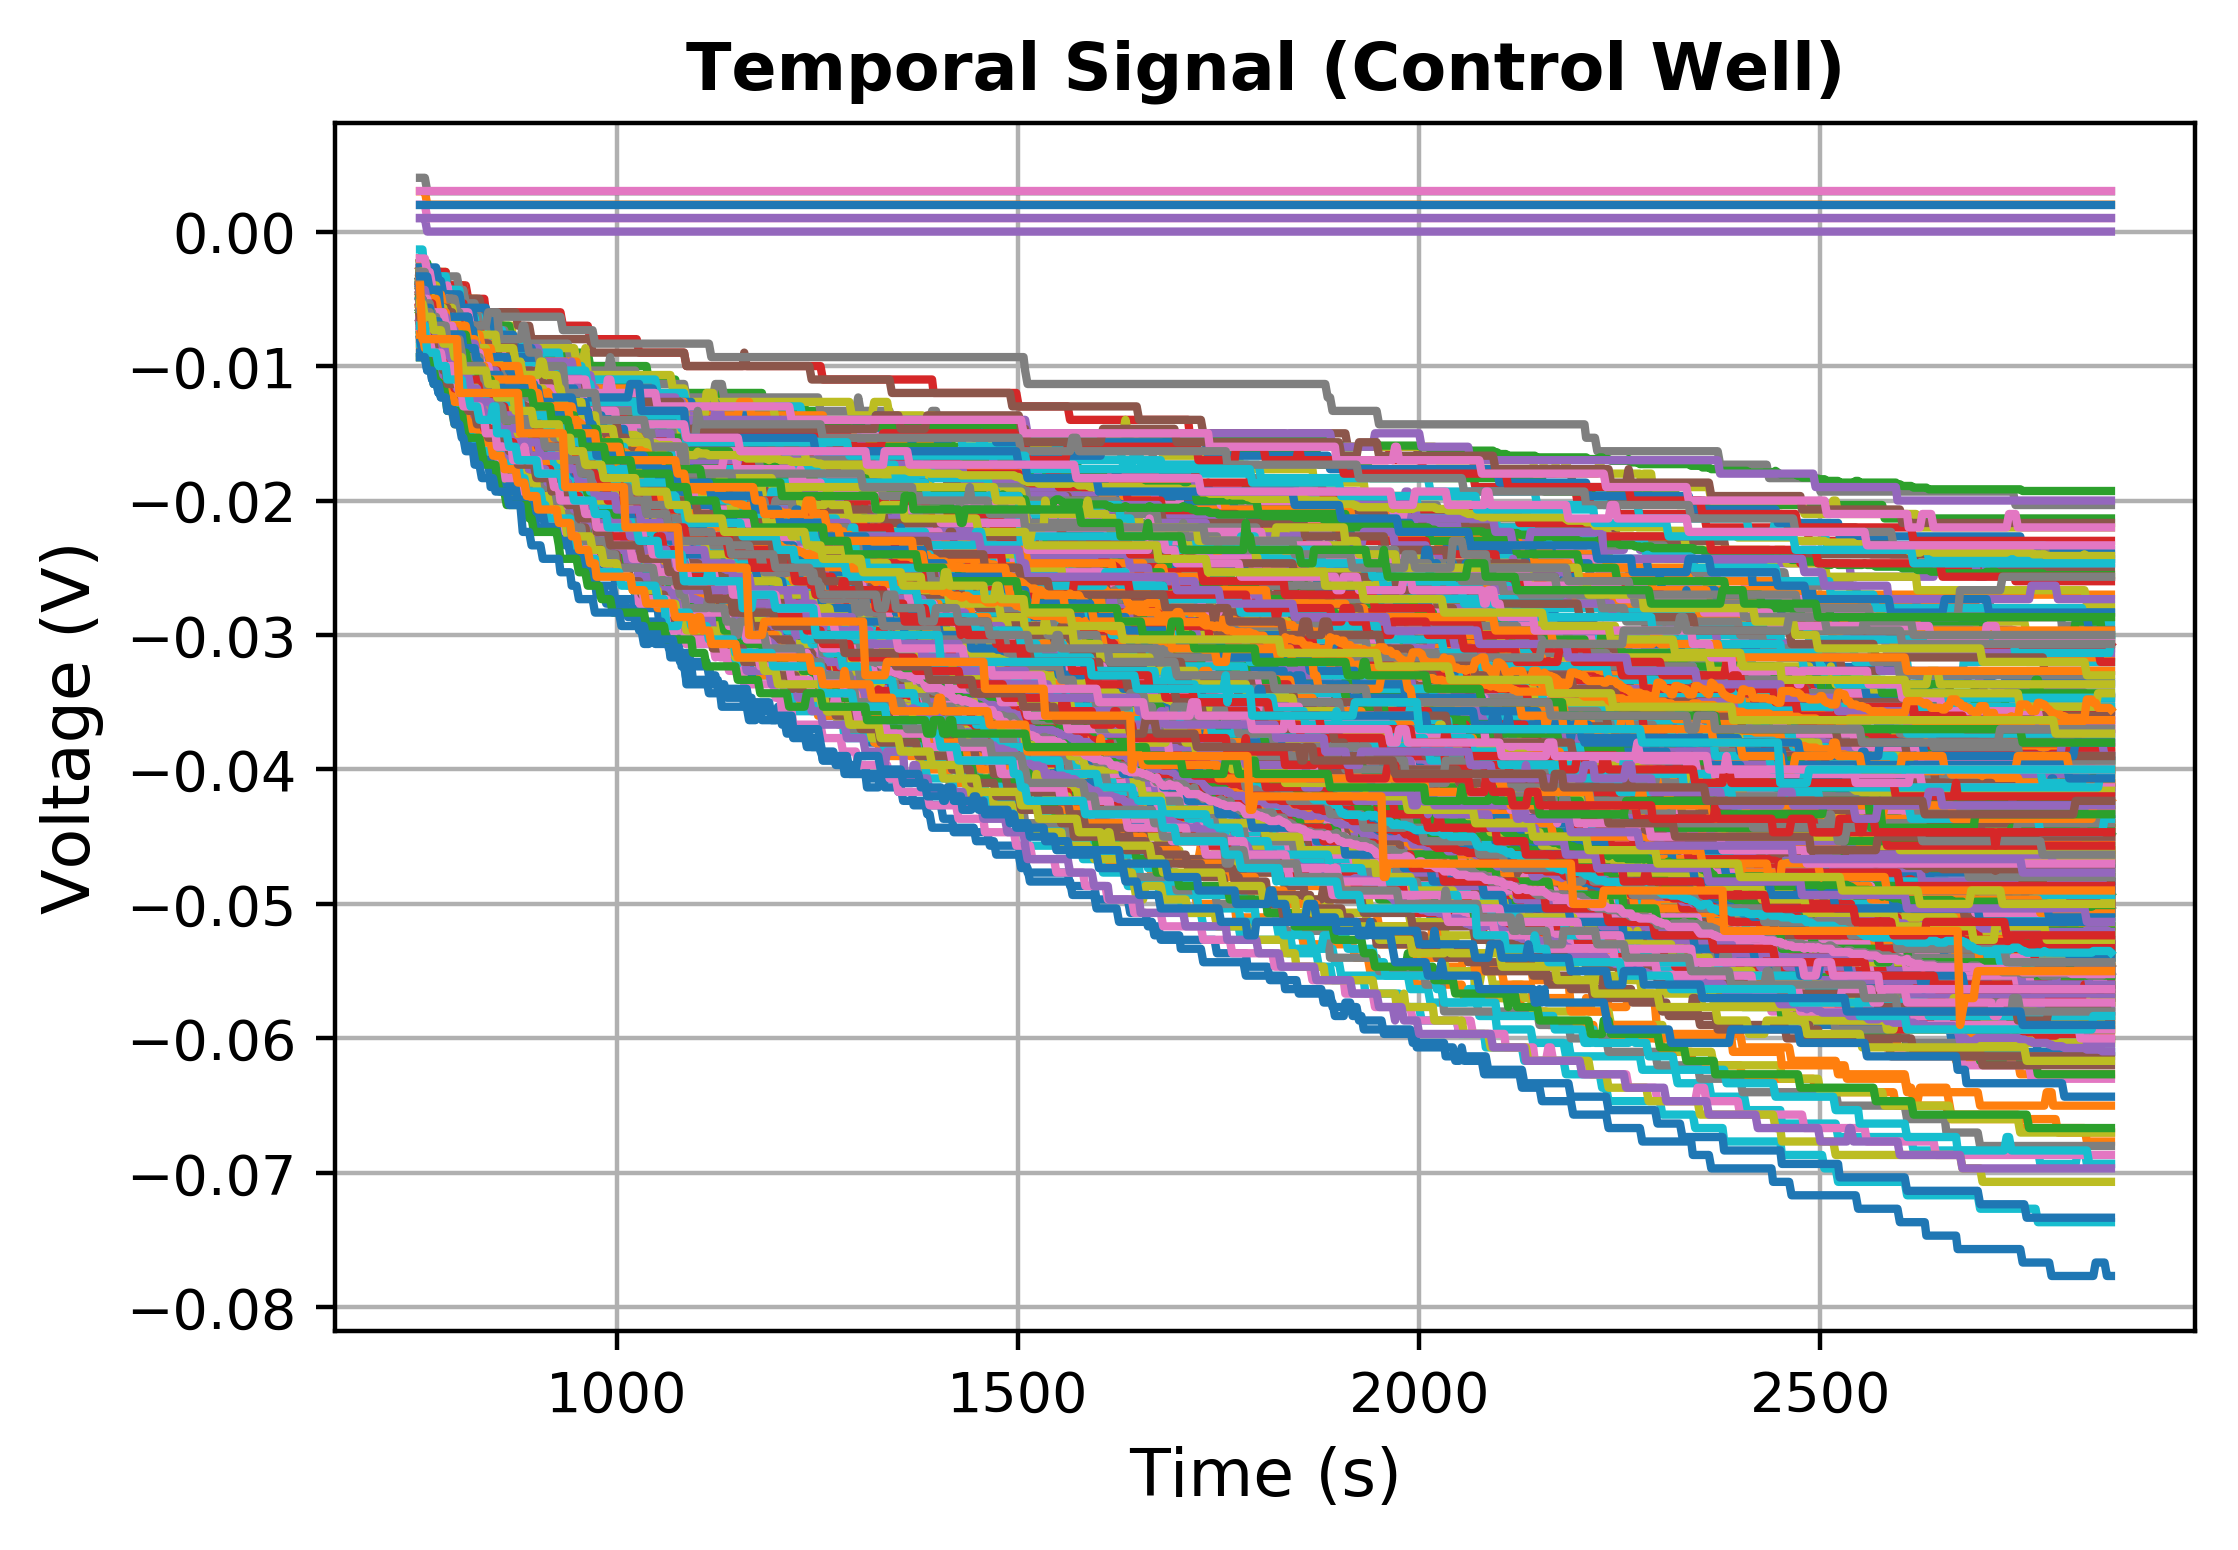

In [241]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Voltage (V)', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Temporal Signal (Control Well)', fontweight='bold')
plt.plot(c_x,c_s)
plt.savefig('Results/real_control_temp.png', bbox_inches='tight')

In [171]:
c_s.shape
# Control well is 771 steps, 712 sensors

(771, 712)

In [172]:
c_x.shape

(771,)

In [174]:
with open("sample_signals_2.txt", "rb") as fp:   # Unpickling
        s_s = pickle.load(fp)/1000

with open("sample_time_2.txt", "rb") as fp1:   # Unpickling
        s_x = pickle.load(fp1)

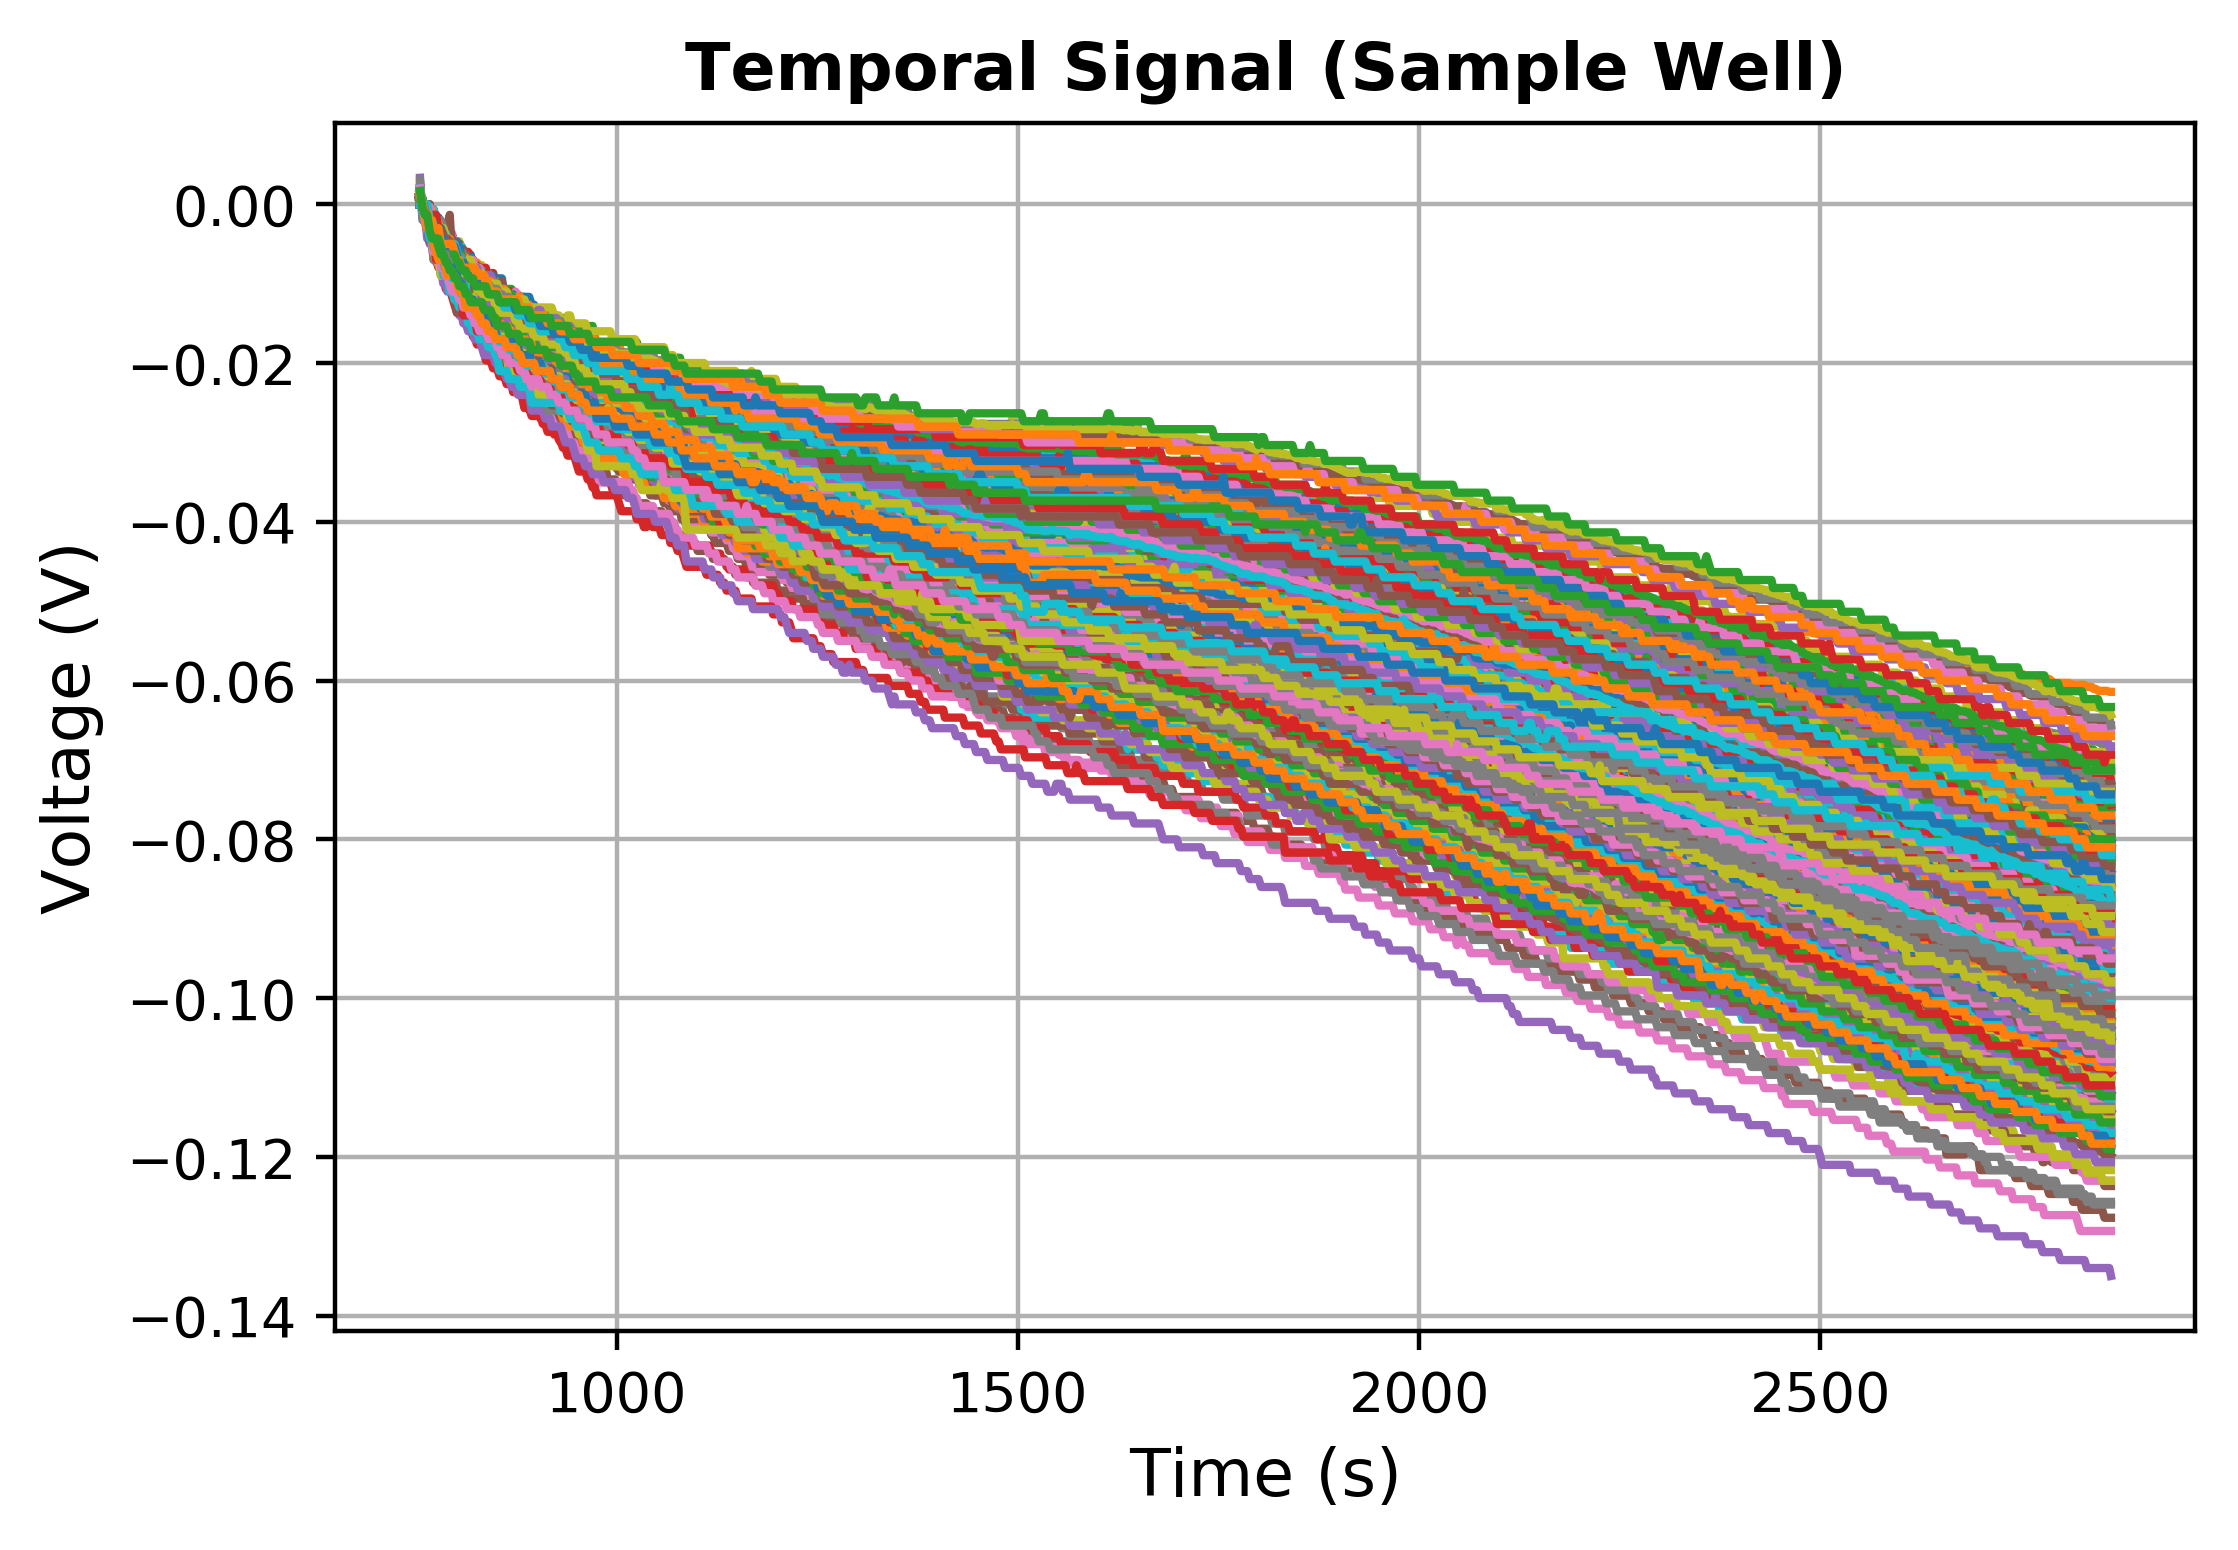

In [242]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Voltage (V)', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Temporal Signal (Sample Well)', fontweight='bold')
plt.plot(s_x, s_s)
plt.savefig('Results/real_sample_temp.png', bbox_inches='tight')

In [178]:
s_s.shape
# Sample well is 759 steps, 593 sensors

(759, 593)

In [179]:
s_x.shape

(759,)

## Data cleaning (make them same number of time steps)

In [180]:
s_x[:5] # verify frame rate is 3 seconds

array([755., 758., 761., 764., 767.])

In [181]:
c_s = c_s[12:]

In [182]:
c_s.shape

(759, 712)

In [183]:
c_x = c_x[12:]

In [216]:
s_x.shape

(759,)

## Model drift for 300 seconds - this is 100 samples

In [185]:
n = 100

In [193]:
data_for_fit_control = c_s[:100].values.T
data_for_fit_sample = s_s[:100].values.T

In [194]:
time_for_fit_control = c_x[:100]
time_for_fit_sample = s_x[:100]

In [195]:
def drift(x,q,beta,tau):
    return (1-np.exp(((x/tau)**beta)*-1))*q

In [196]:
drift_control = np.zeros(c_s.shape)
drift_sample = np.zeros(s_s.shape)

In [197]:
data_for_fit_sample

array([[ 0.001     ,  0.        , -0.001     , ..., -0.03      ,
        -0.03      , -0.03      ],
       [ 0.001     ,  0.        , -0.001     , ..., -0.032     ,
        -0.032     , -0.032     ],
       [ 0.002     , -0.001     , -0.001     , ..., -0.032     ,
        -0.032     , -0.033     ],
       ...,
       [ 0.001     ,  0.        , -0.001     , ..., -0.029     ,
        -0.029     , -0.029     ],
       [ 0.001     ,  0.        , -0.001     , ..., -0.028     ,
        -0.028     , -0.028     ],
       [ 0.00166667, -0.00033333, -0.00133333, ..., -0.02433333,
        -0.02433333, -0.02433333]])

In [198]:
n_sensors = data_for_fit_sample.shape[0]
for i in range(0, n_sensors):
    popt_pos,_ = curve_fit(drift, time_for_fit_sample, data_for_fit_sample[i,:], bounds = ((-1.5, 0, 300),(0,2,10000)))
    sensor_drift = drift(s_x, *popt_pos)
    #sensor_drift = np.append(np.nan, sensor_drift)
    drift_sample[:,i] = sensor_drift

In [199]:
n_sensors = data_for_fit_control.shape[0]
for i in range(0, n_sensors):
    popt_pos,_ = curve_fit(drift, time_for_fit_control, data_for_fit_control[i,:], bounds = ((-1.5, 0, 300),(0,2,10000)))
    sensor_drift = drift(s_x, *popt_pos)
    #sensor_drift = np.append(np.nan, sensor_drift)
    drift_control[:,i] = sensor_drift

## Perform Drift Correction

In [200]:
corrected_sample = s_s[100:] - drift_sample[100:]

In [201]:
corrected_control = c_s[100:] - drift_control[100:]

In [202]:
remaining_time_sample = s_x[100:]
remaining_time_control = c_x[100:]

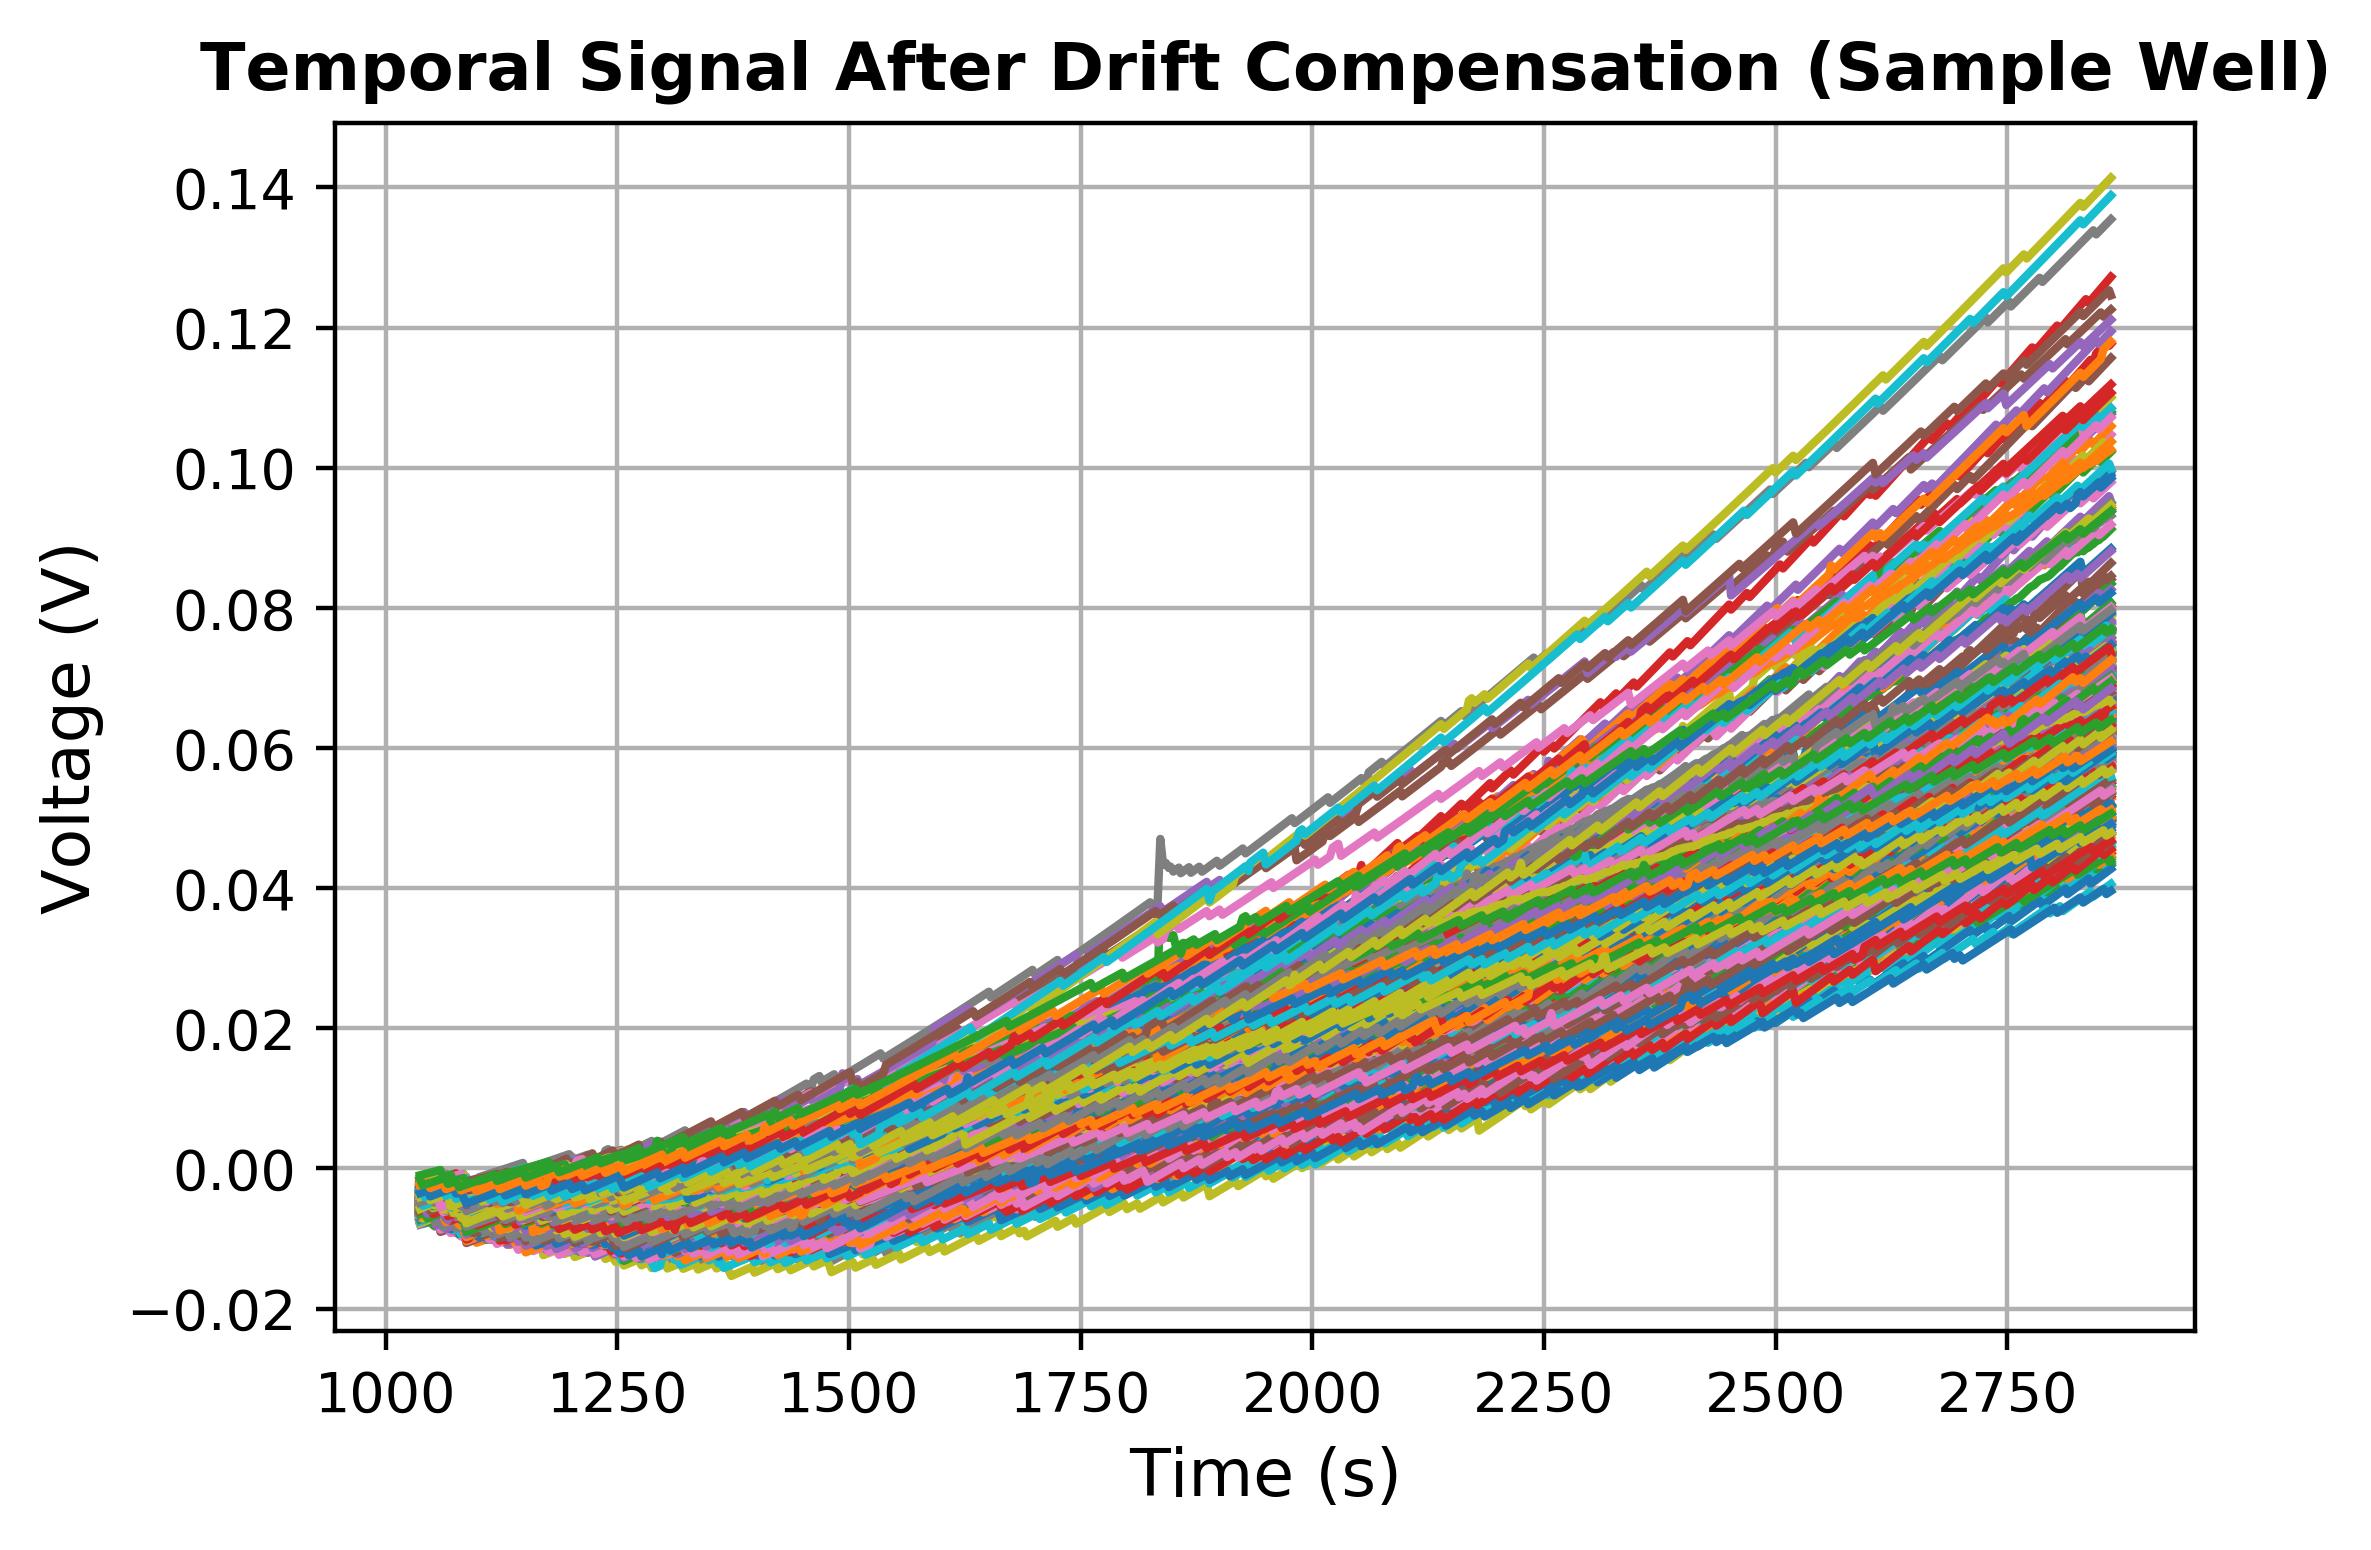

In [243]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Voltage (V)', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Temporal Signal After Drift Compensation (Sample Well)', fontweight='bold')
plt.plot(remaining_time_sample, corrected_sample)
plt.savefig('Results/real_sample_corrected.png', bbox_inches='tight')

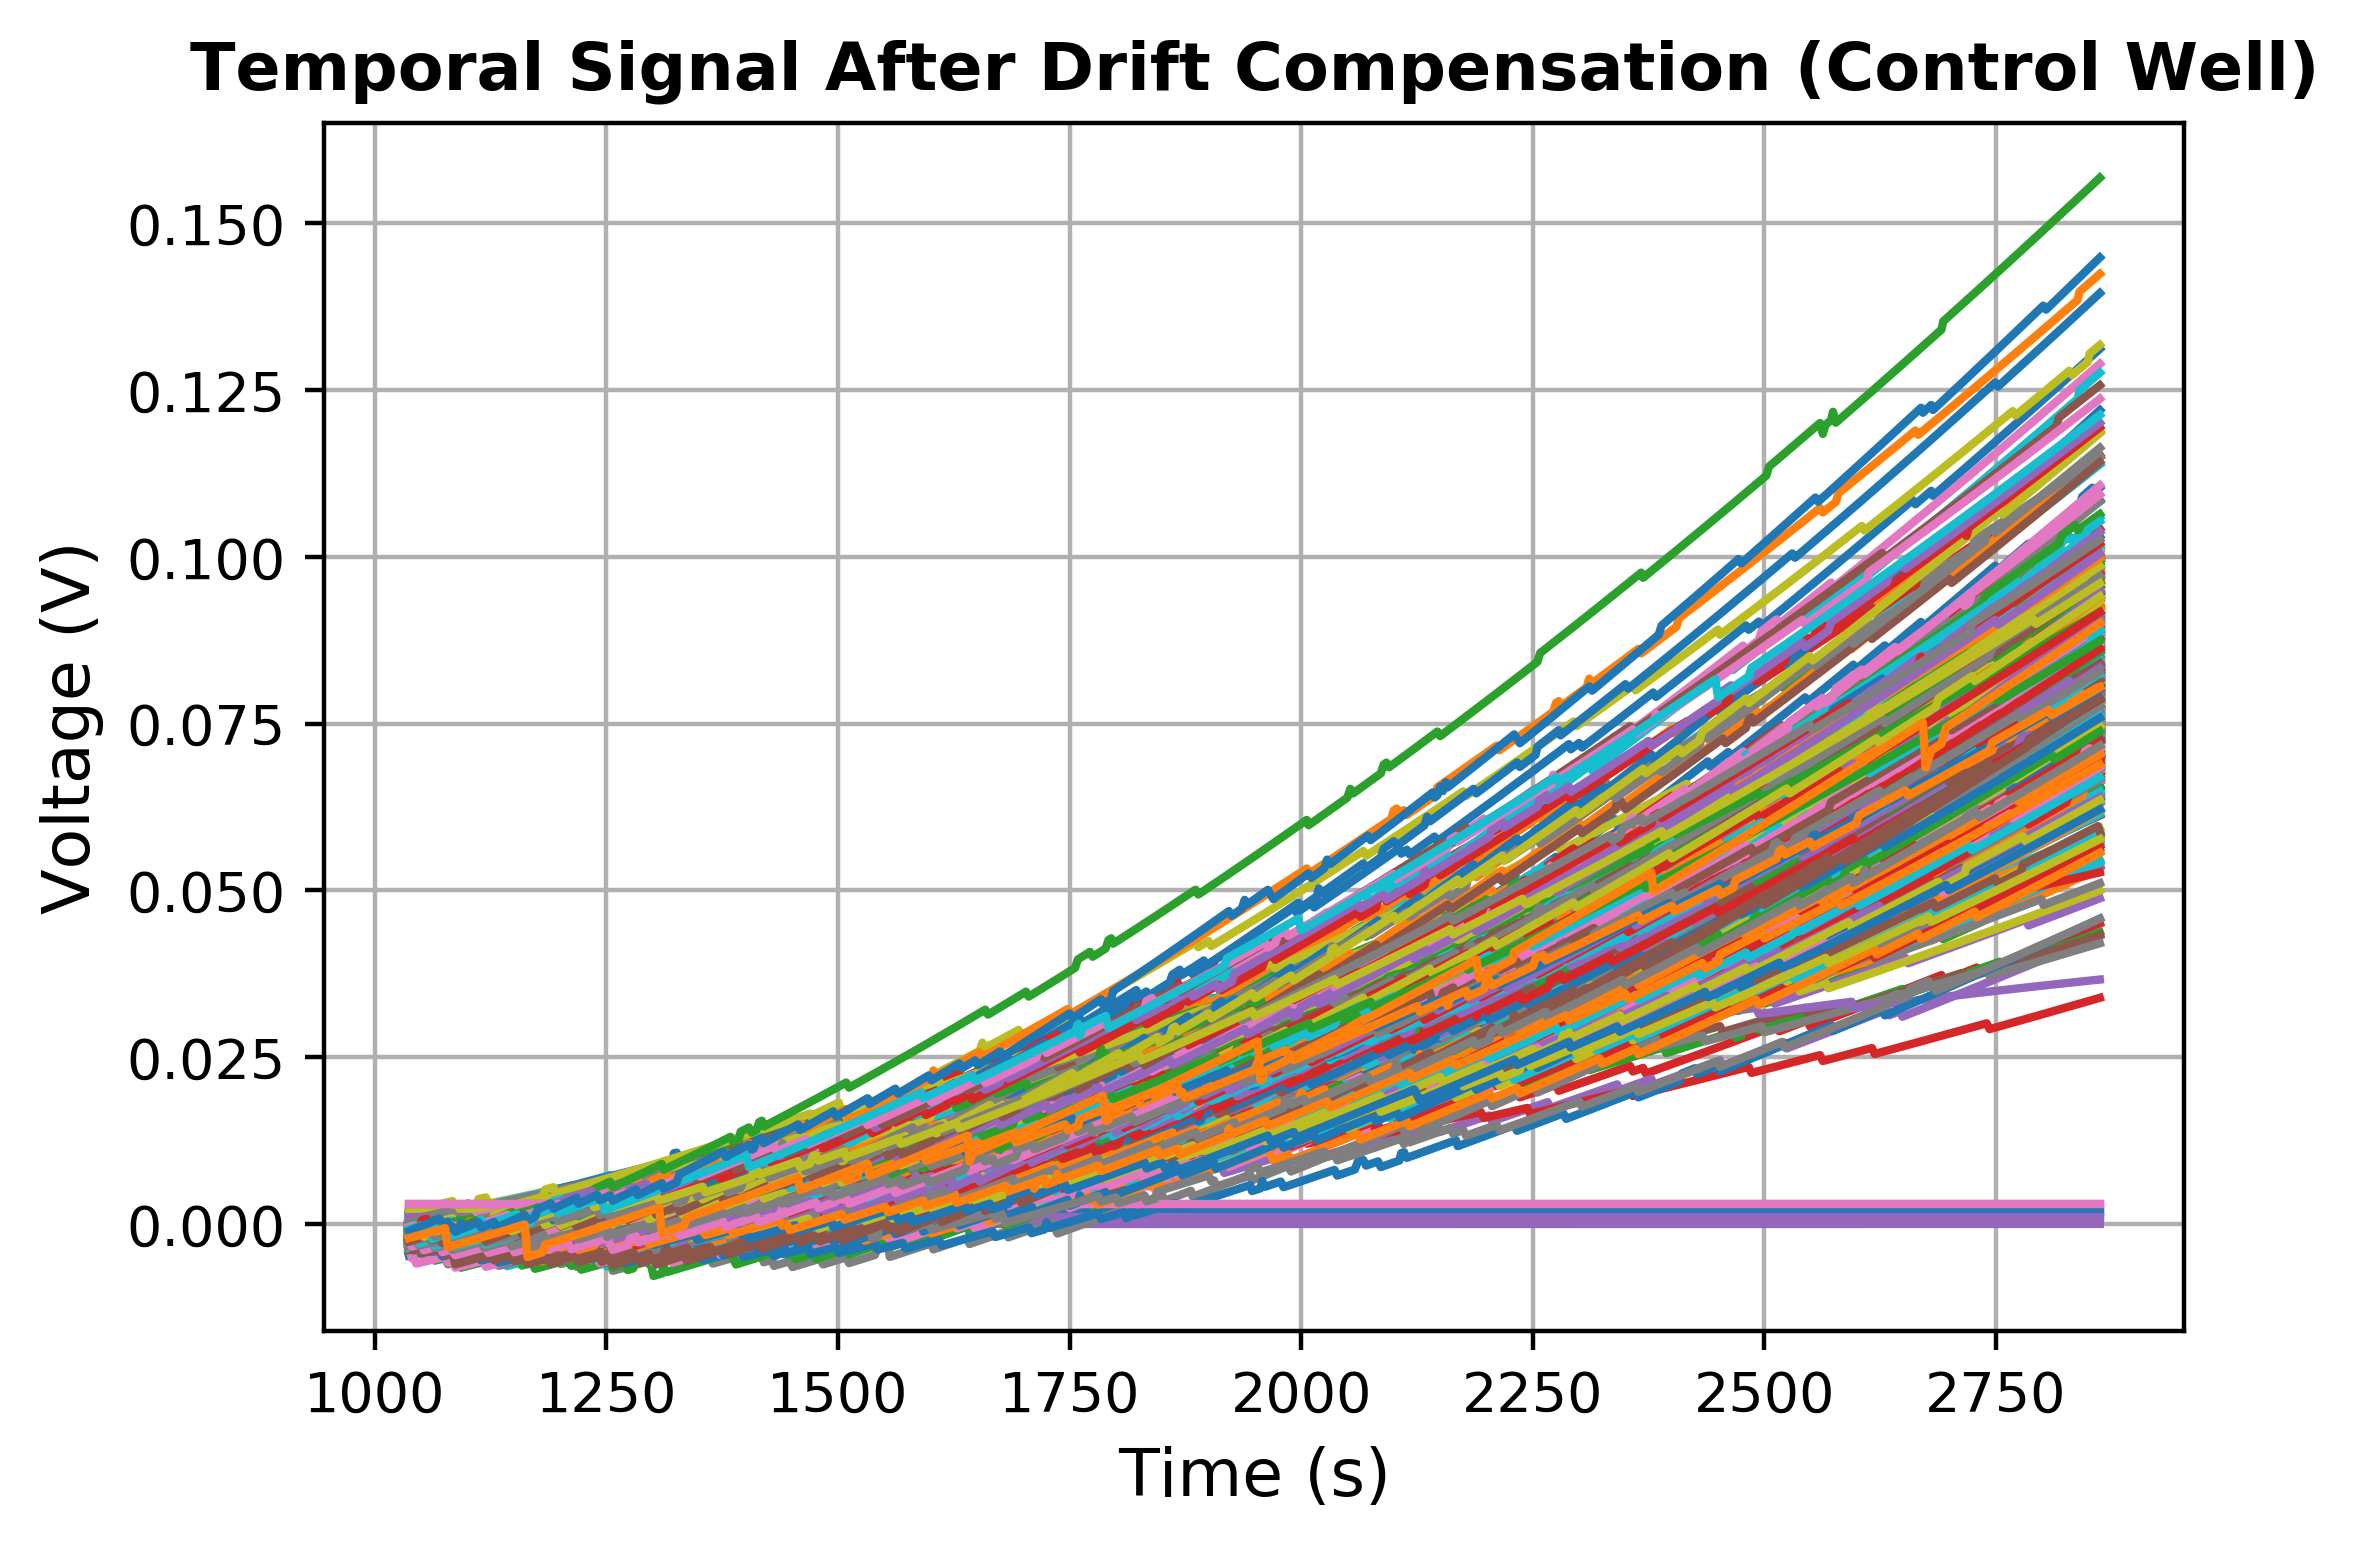

In [244]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Voltage (V)', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Temporal Signal After Drift Compensation (Control Well)', fontweight='bold')
plt.plot(remaining_time_control, corrected_control)
plt.savefig('Results/real_control_corrected.png', bbox_inches='tight')

## Get spatial standard deviation

In [205]:
sample_std = np.std(corrected_sample.T, axis=0)

In [206]:
sample_std.shape

(659,)

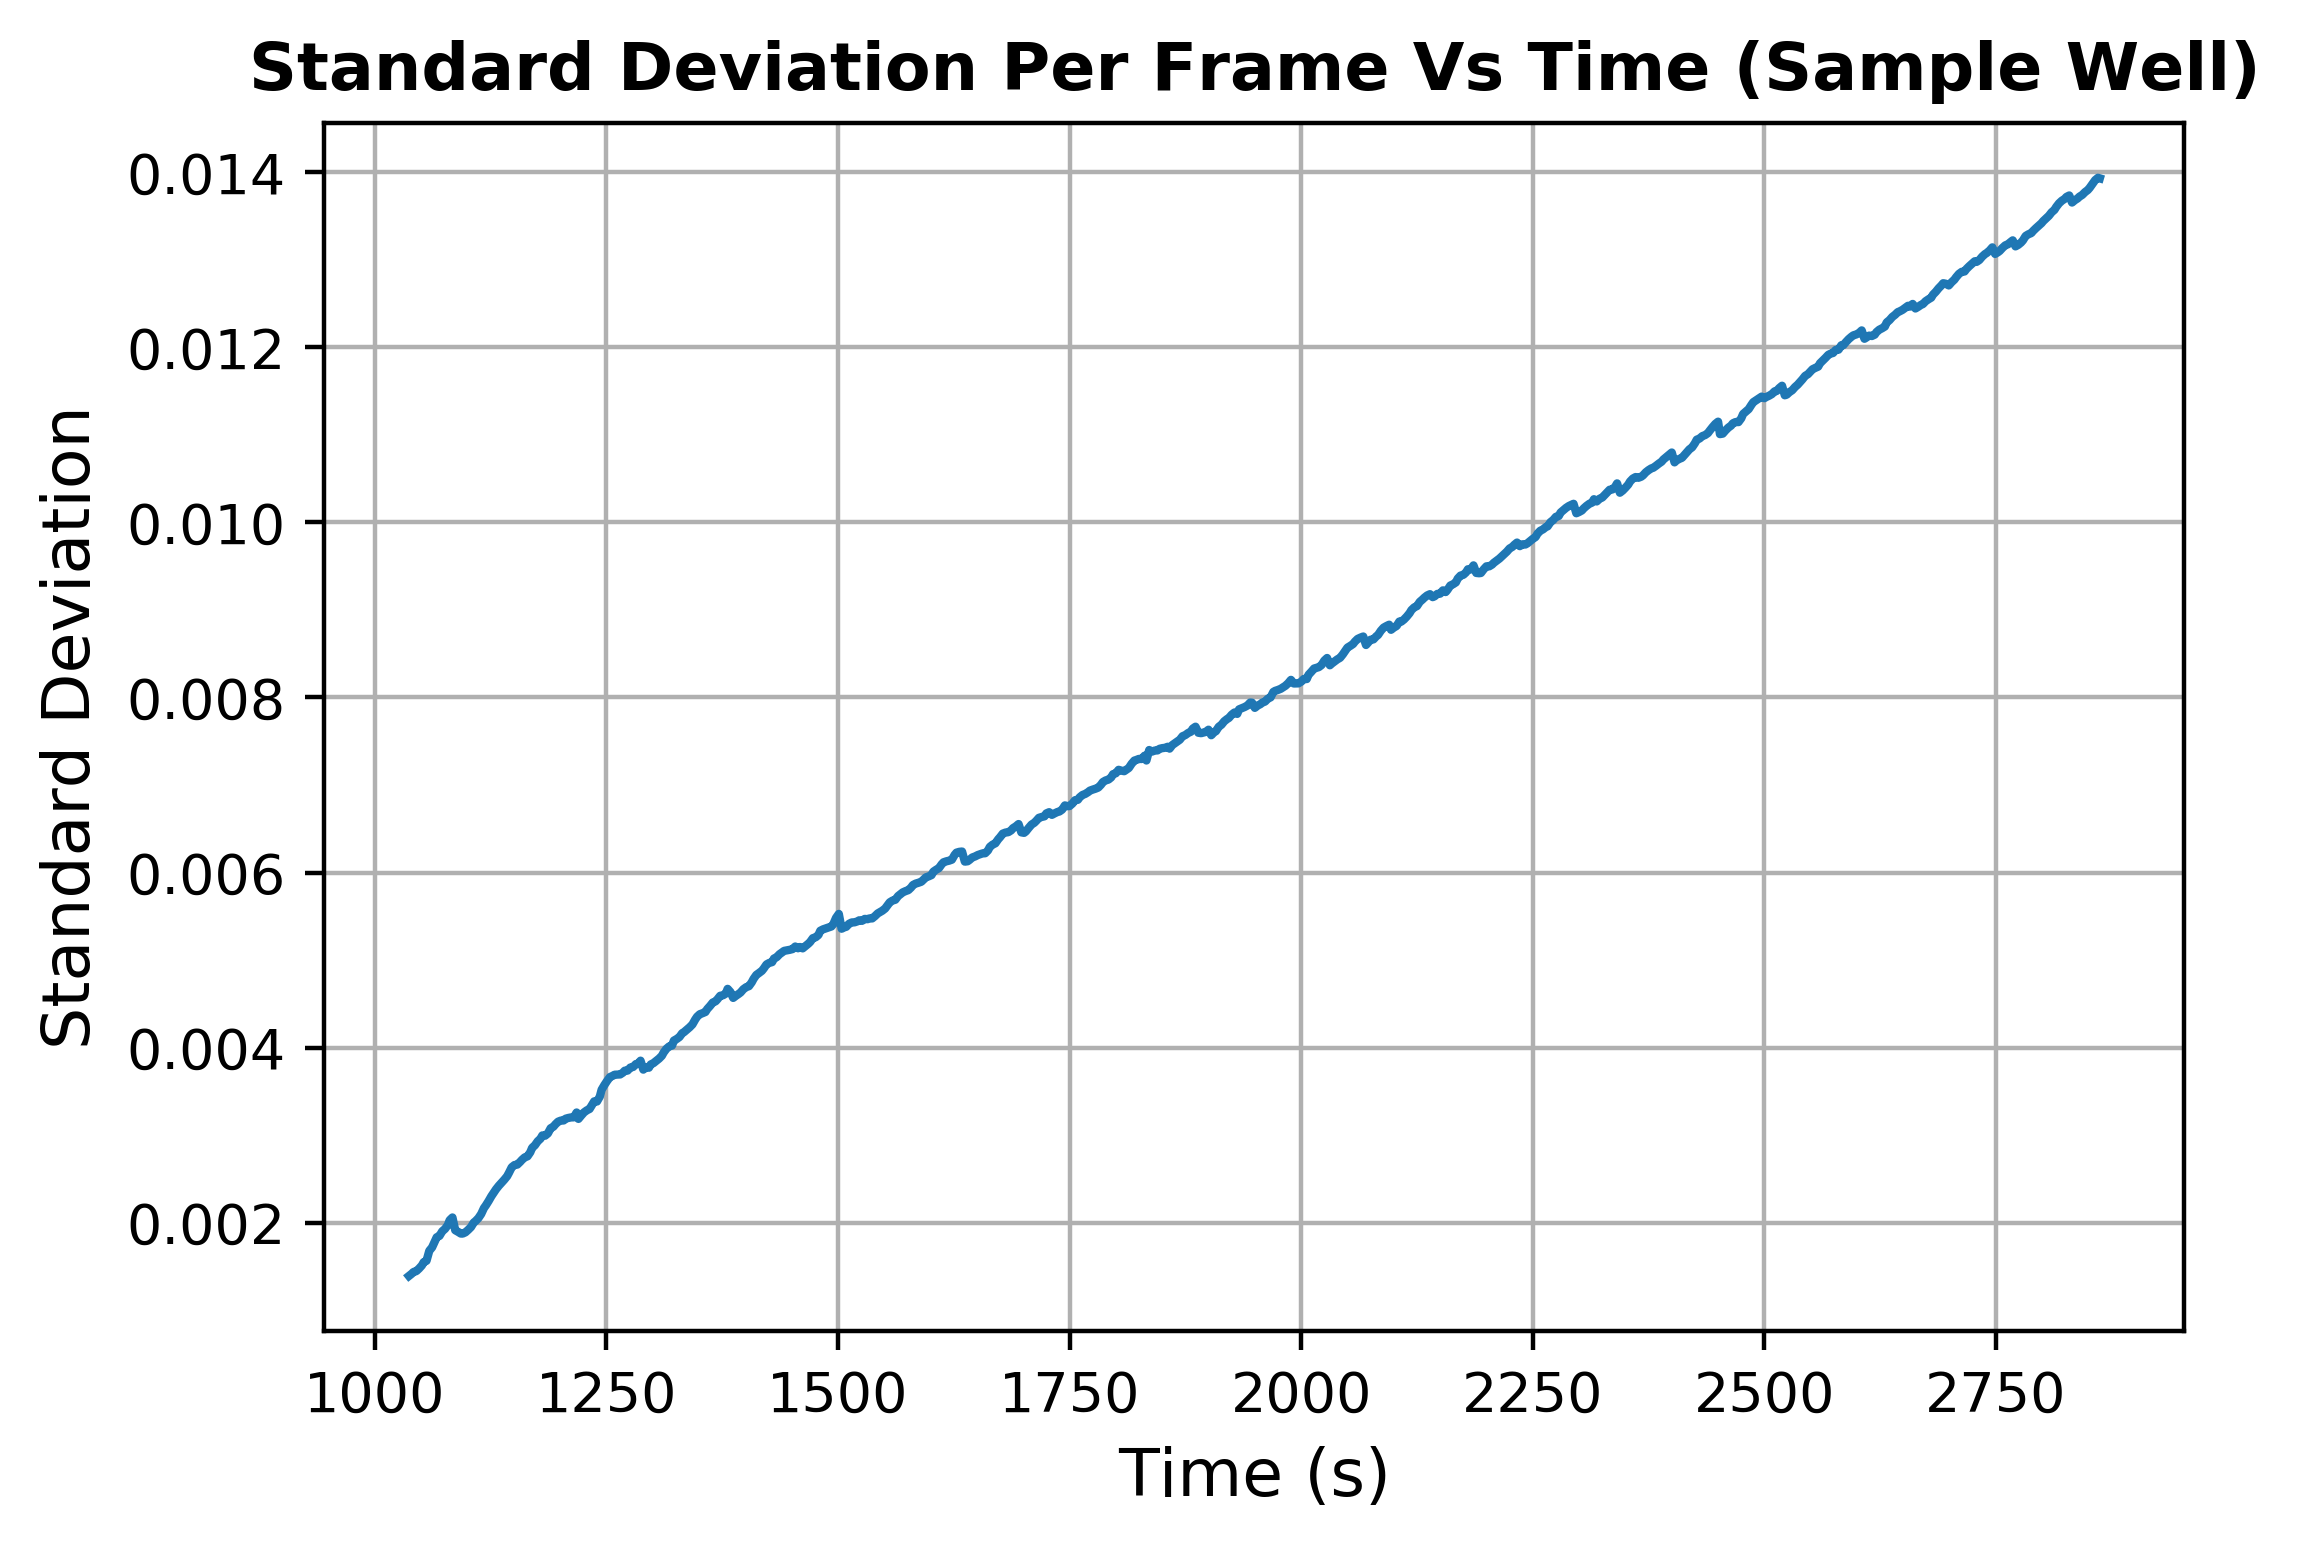

In [245]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Standard Deviation', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Standard Deviation Per Frame Vs Time (Sample Well)', fontweight='bold')
plt.plot(remaining_time_sample, sample_std)
plt.savefig('Results/real_sample_std.png', bbox_inches='tight')

In [208]:
control_std = np.std(corrected_control.T, axis=0)

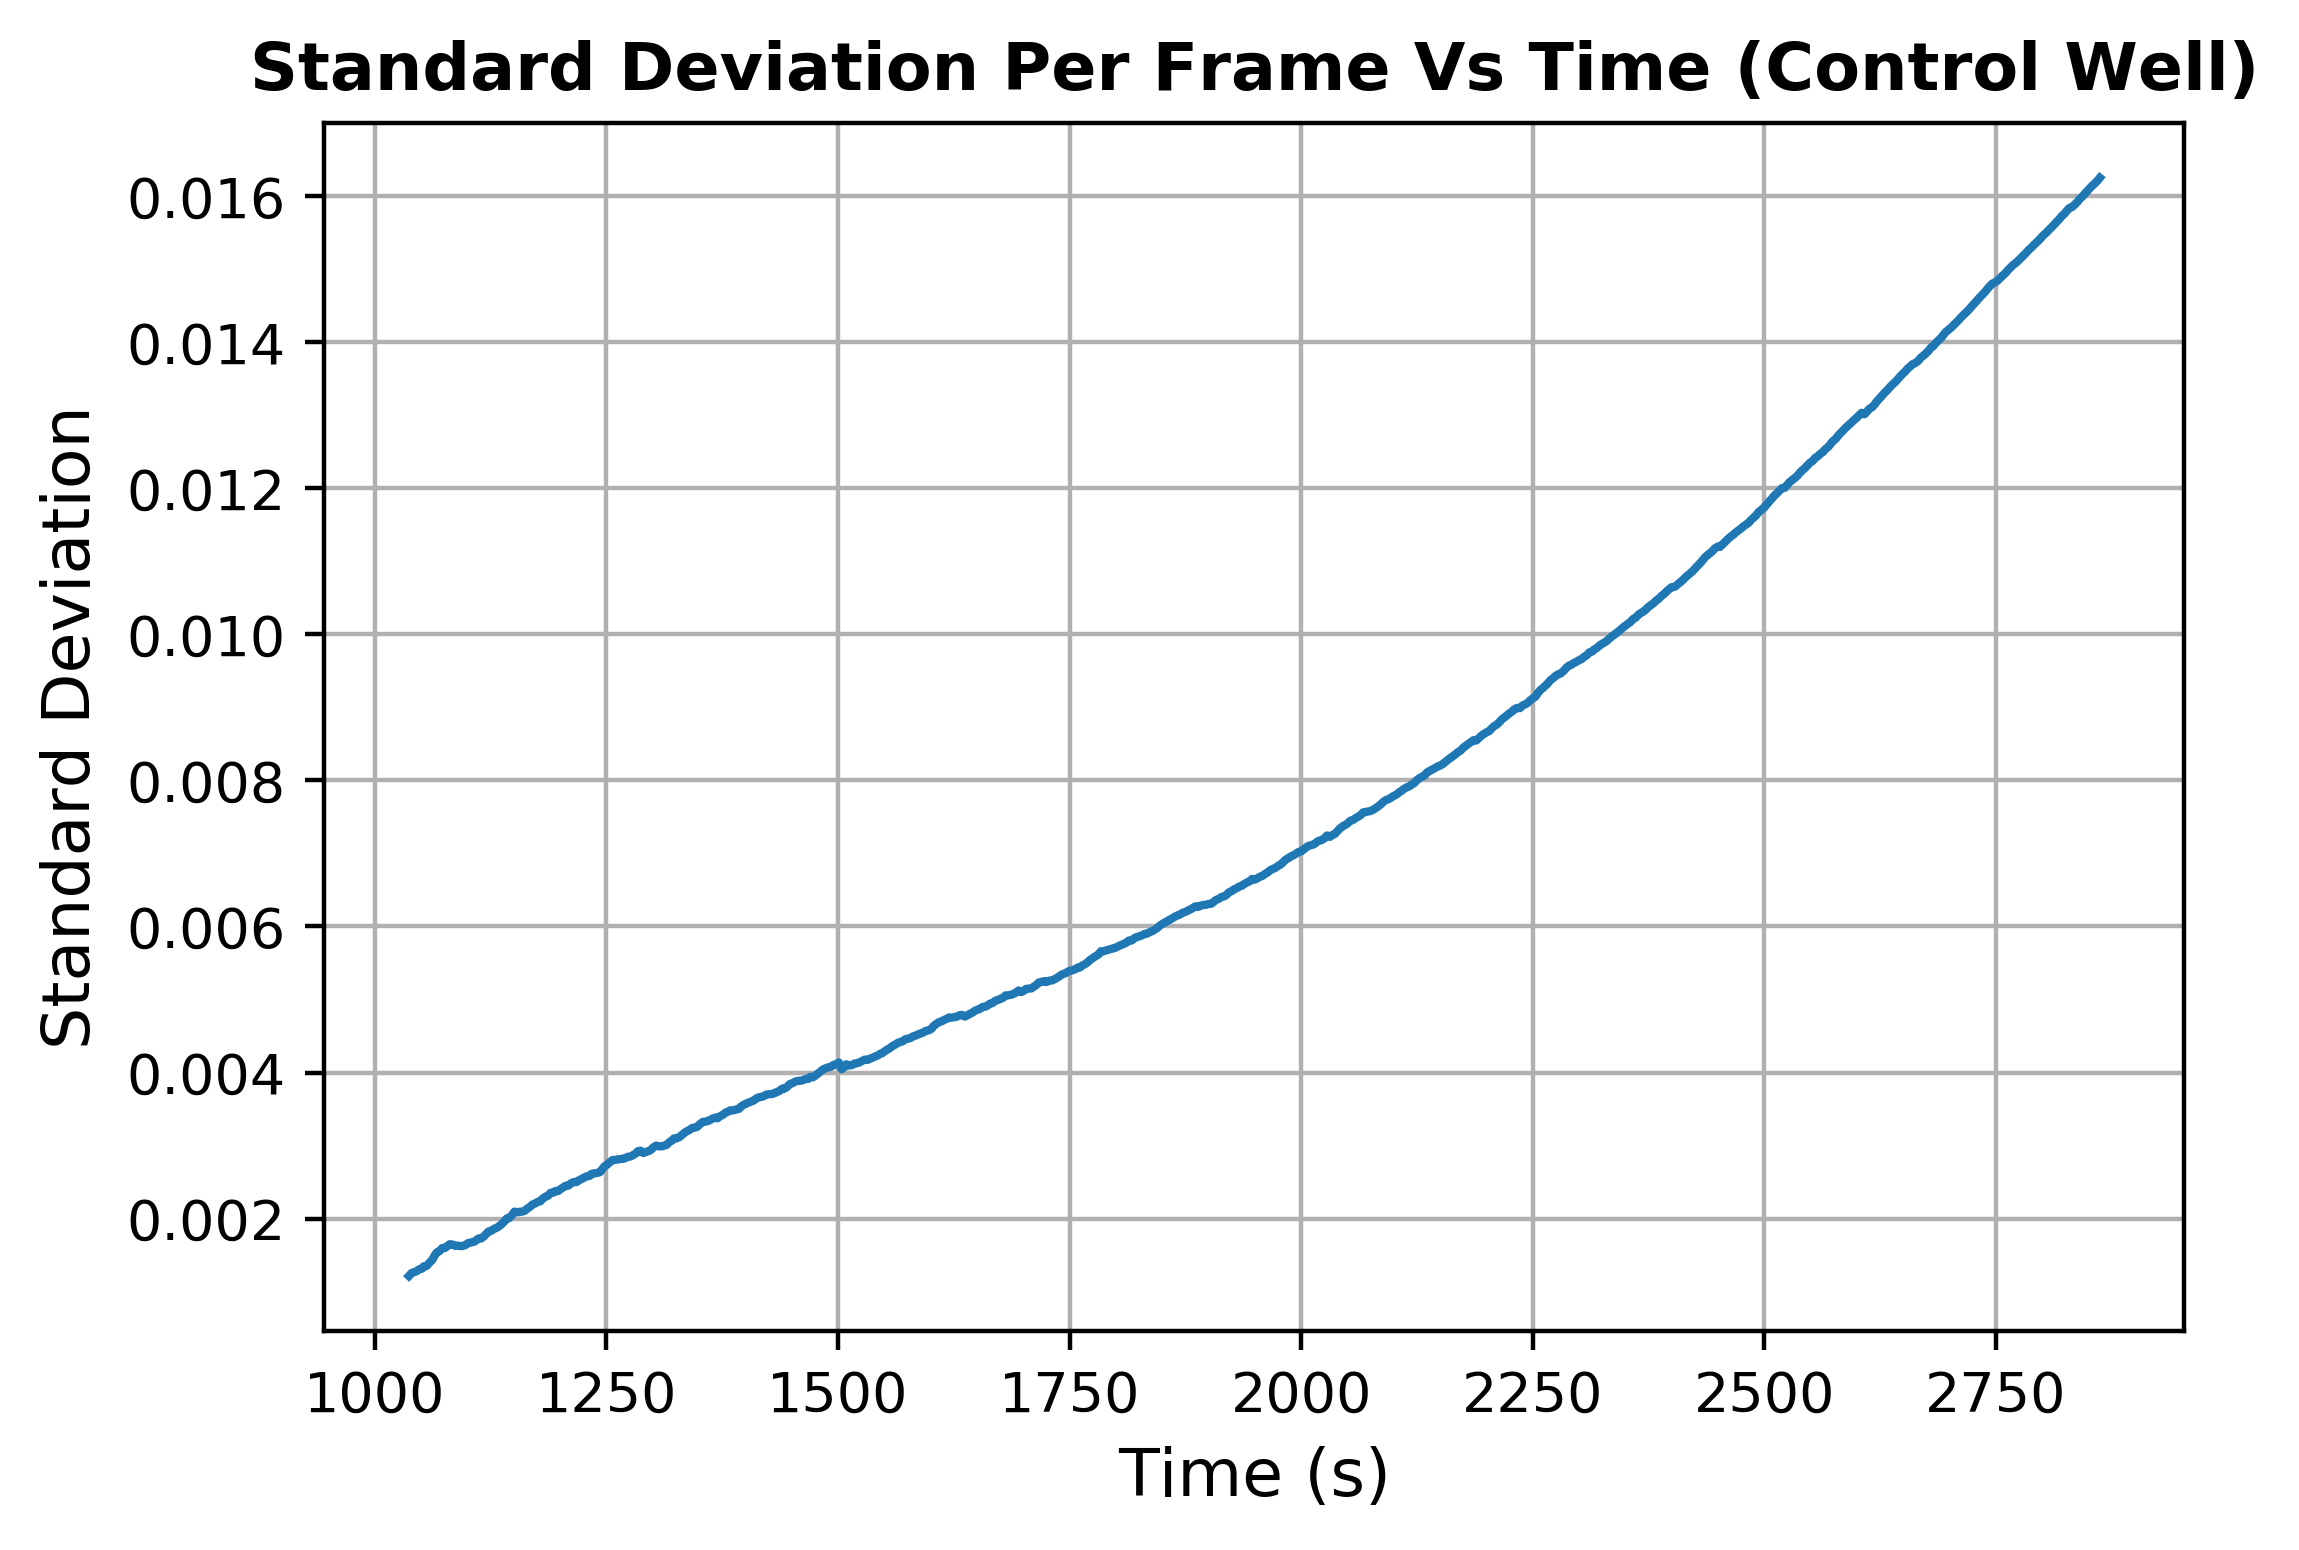

In [246]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Standard Deviation', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Standard Deviation Per Frame Vs Time (Control Well)', fontweight='bold')
plt.plot(remaining_time_control, control_std)
plt.savefig('Results/real_control_std.png', bbox_inches='tight')

In [210]:
std_diff = sample_std-control_std

In [217]:
std_diff = std_diff[12:]

In [224]:
type(std_diff)

pandas.core.series.Series

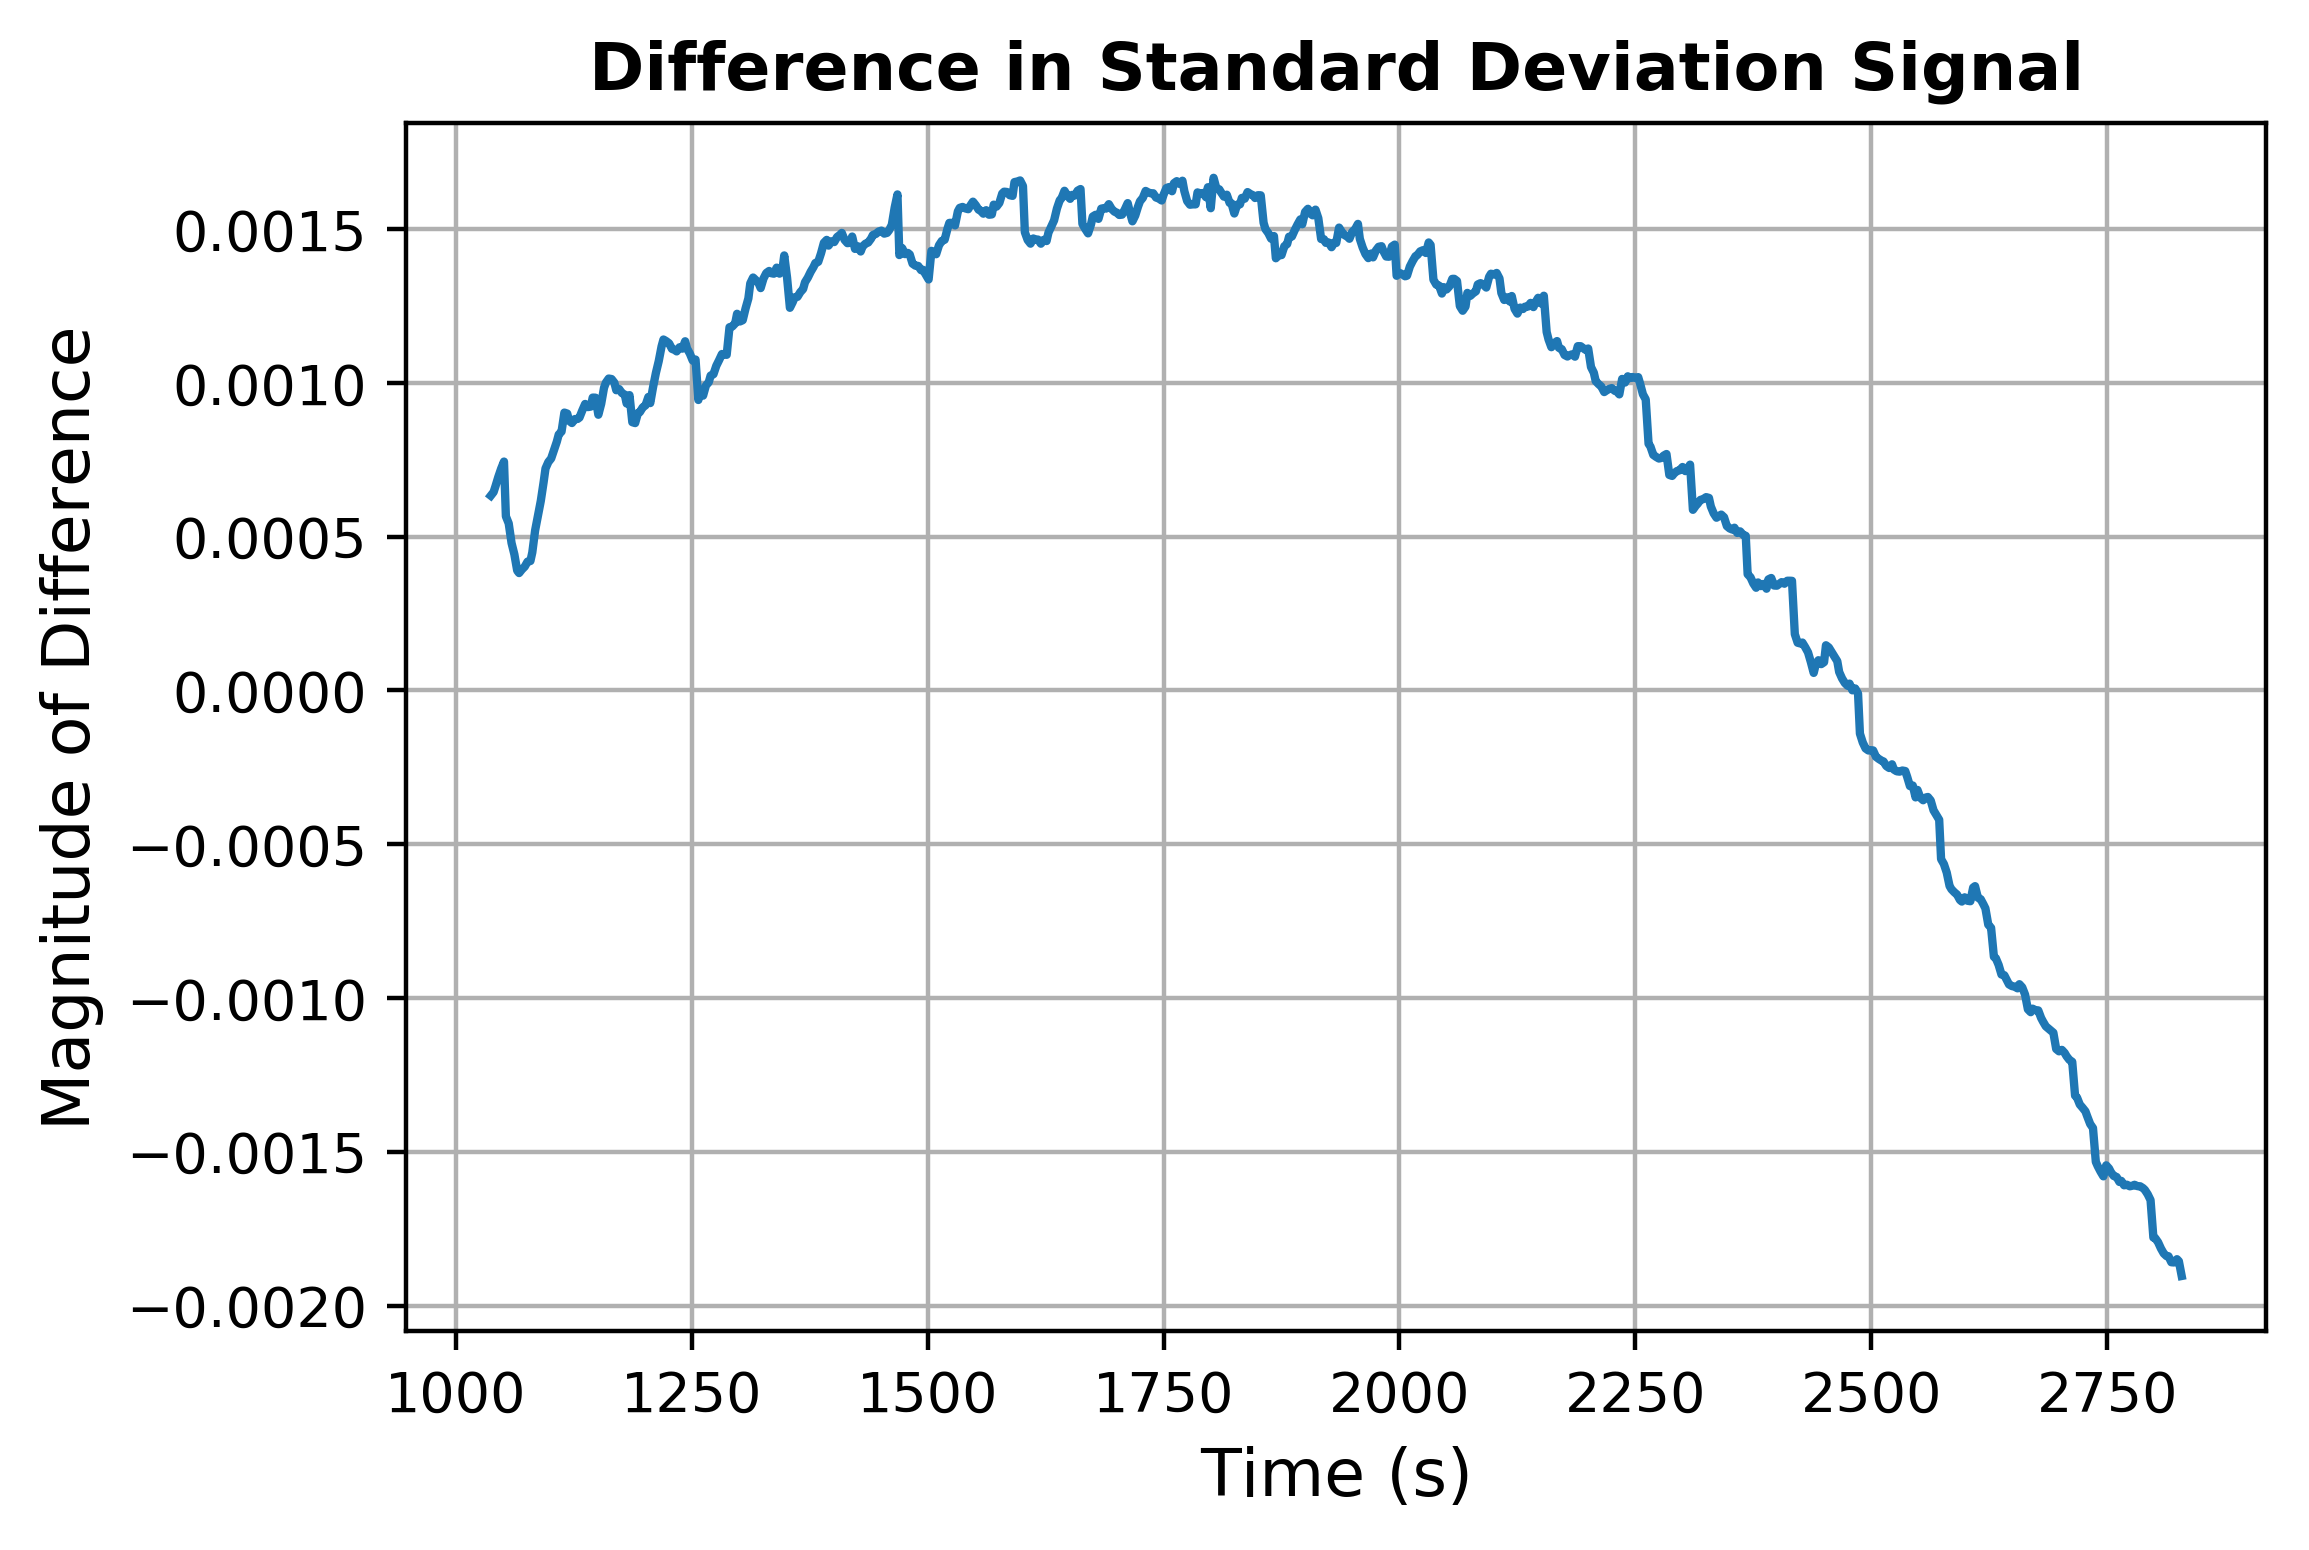

In [248]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Magnitude of Difference', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Difference in Standard Deviation Signal', fontweight='bold')
plt.plot(remaining_time_control, std_diff)
plt.savefig('Results/real_diff_std.png', bbox_inches='tight')

In [219]:
def return_rolling_difference(series):
    diffs = []
    for i in range(1, len(series)):
        diffs.append((series[i] - series[i-1])/3)
    return np.array(diffs)

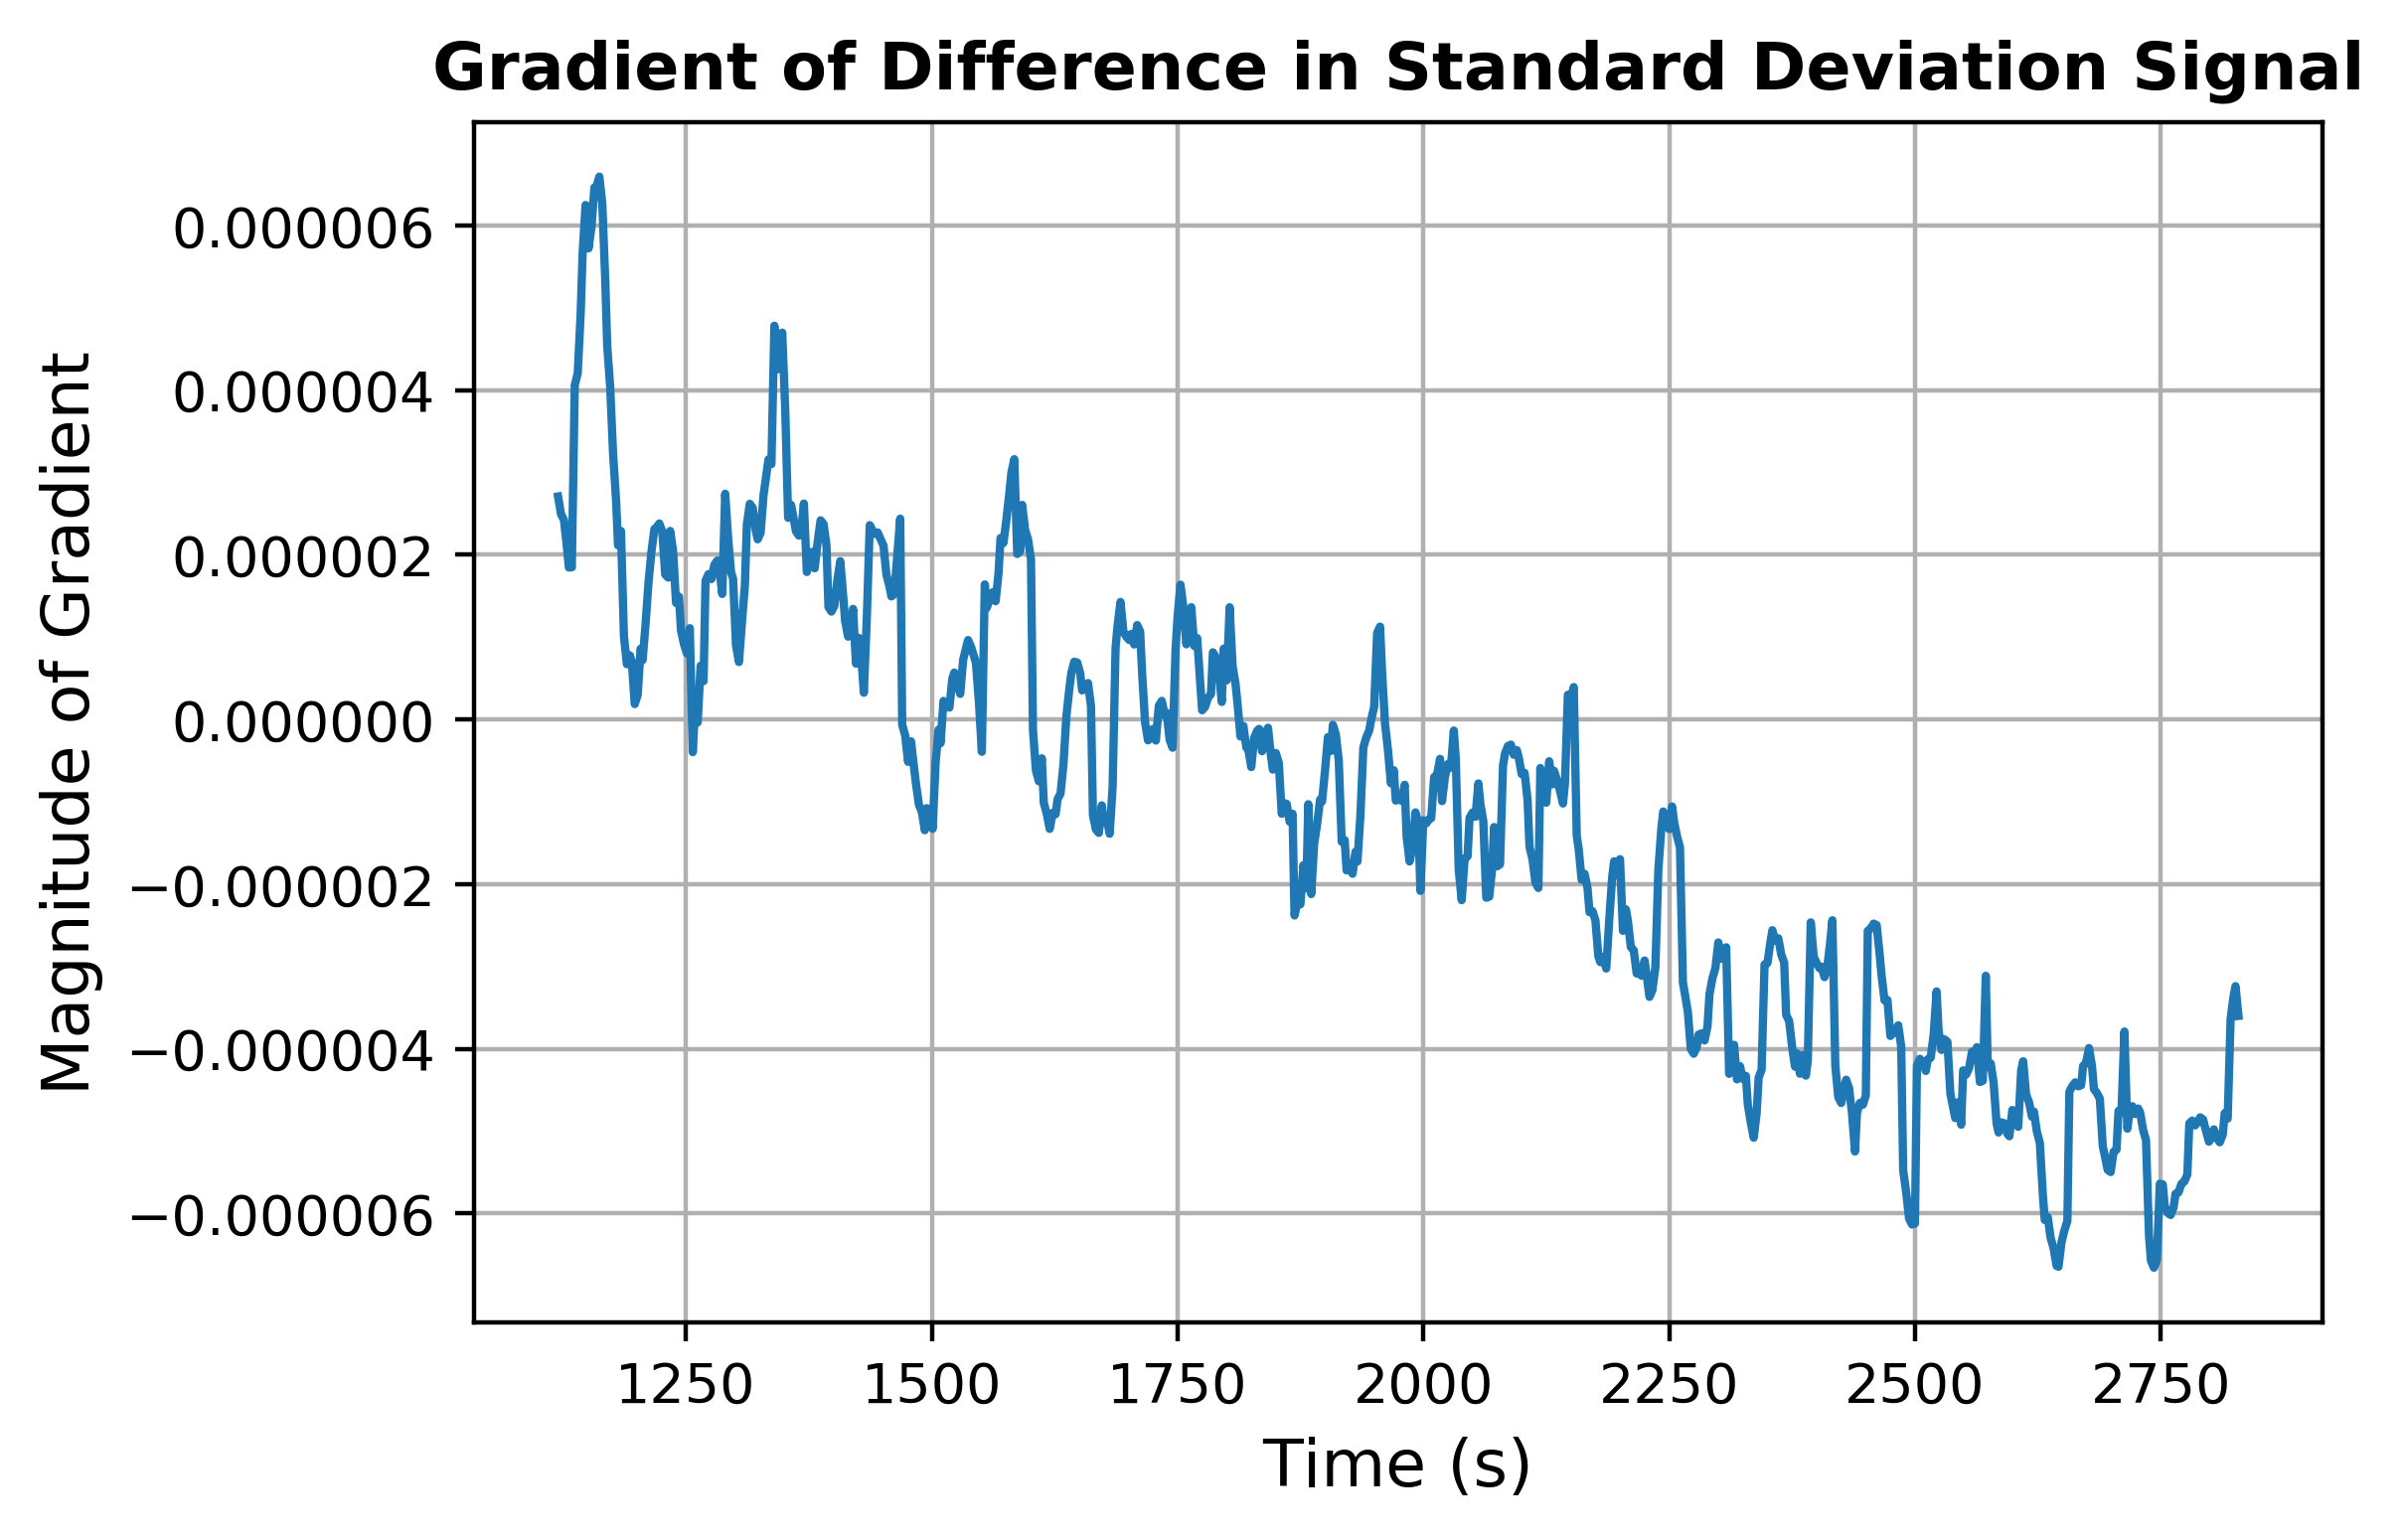

In [249]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Magnitude of Gradient', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Gradient of Difference in Standard Deviation Signal', fontweight='bold')
plt.plot(remaining_time_control[1:], return_rolling_difference(std_diff.rolling(30).mean().values))
plt.savefig('Results/grad_diff_std.png', bbox_inches='tight')

In [150]:
std_diff

array([ 1.26606403e-04,  1.34657792e-04,  1.41307442e-04,  1.49566275e-04,
        1.58653782e-04,  1.68243074e-04,  1.77548001e-04,  1.87573459e-04,
        1.99421859e-04,  2.11555196e-04,  2.23610651e-04,  2.35213692e-04,
        2.46605921e-04,  2.57331329e-04,  2.68529625e-04,  2.78888385e-04,
        2.88751636e-04,  2.99645084e-04,  3.03599503e-04,  3.06399408e-04,
        3.08538178e-04,  3.10325457e-04,  3.12763699e-04,  3.15619412e-04,
        3.20138044e-04,  3.25219349e-04,  3.28778994e-04,  3.32541495e-04,
        3.39831990e-04,  3.47845863e-04,  3.55908172e-04,  3.65423085e-04,
        3.75687068e-04,  3.86345094e-04,  3.97456148e-04,  4.09073485e-04,
        4.21020401e-04,  4.32123065e-04,  4.40908009e-04,  4.50433817e-04,
        4.60981236e-04,  4.70217650e-04,  4.79971798e-04,  4.90576414e-04,
        5.00472677e-04,  5.10908582e-04,  5.19372553e-04,  5.27239774e-04,
        5.42463810e-04,  5.58938195e-04,  5.76194352e-04,  5.93943498e-04,
        6.11310046e-04,  

## Compare to temporal

In [229]:
s_s_avg = np.mean(corrected_sample, axis=1)

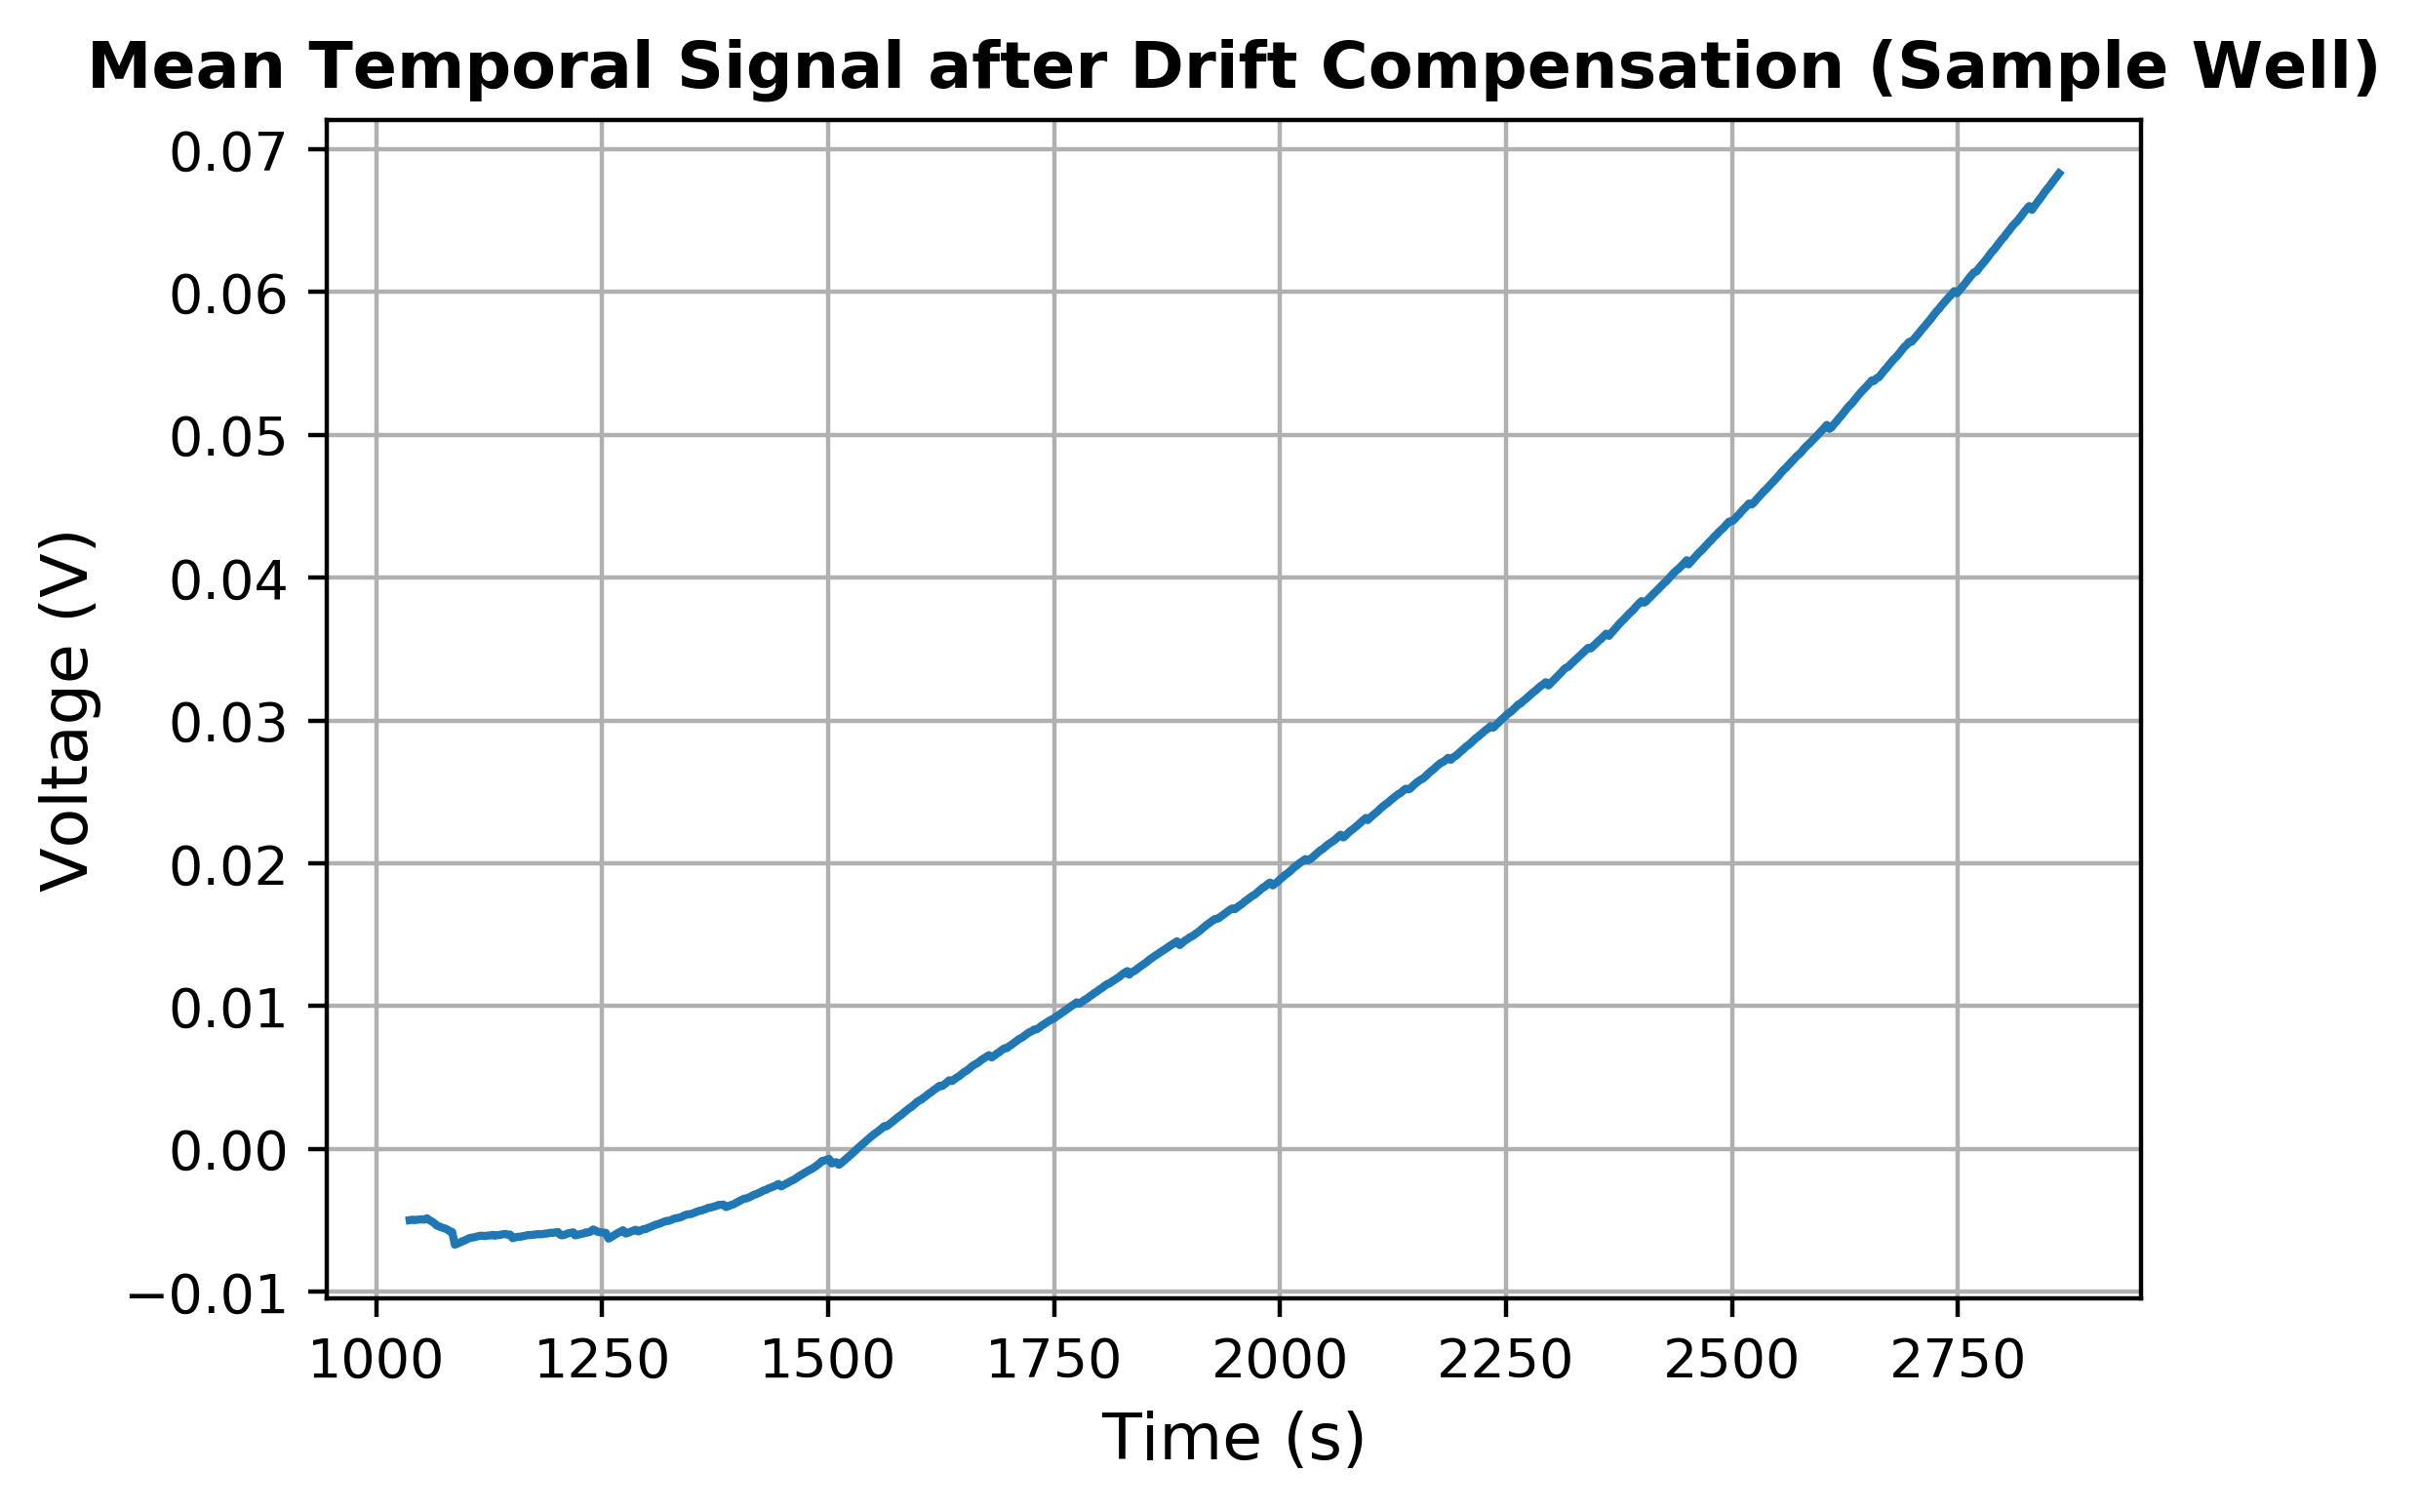

In [250]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Voltage (V)', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Mean Temporal Signal after Drift Compensation (Sample Well)', fontweight='bold')
plt.plot(remaining_time_sample, s_s_avg)
plt.savefig('Results/real_temporal_corrected.png', bbox_inches='tight')

In [237]:
grad = return_rolling_difference(pd.DataFrame(s_s_avg).rolling(30).mean().values)

In [232]:
s_s_avg

100   -0.005000
101   -0.004970
102   -0.005002
103   -0.004975
104   -0.004956
105   -0.004941
106   -0.004970
107   -0.004870
108   -0.005015
109   -0.005111
110   -0.005258
111   -0.005384
112   -0.005450
113   -0.005530
114   -0.005586
115   -0.005672
116   -0.005776
117   -0.005833
118   -0.006721
119   -0.006640
120   -0.006555
121   -0.006486
122   -0.006421
123   -0.006323
124   -0.006243
125   -0.006214
126   -0.006194
127   -0.006138
128   -0.006094
129   -0.006099
         ...   
729    0.062335
730    0.062602
731    0.062847
732    0.062970
733    0.063227
734    0.063474
735    0.063716
736    0.063846
737    0.064107
738    0.064339
739    0.064598
740    0.064810
741    0.064924
742    0.065150
743    0.065400
744    0.065660
745    0.065802
746    0.066029
747    0.065764
748    0.066046
749    0.066296
750    0.066469
751    0.066719
752    0.066999
753    0.067239
754    0.067381
755    0.067648
756    0.067893
757    0.068147
758    0.068314
Length: 659, dtype: floa

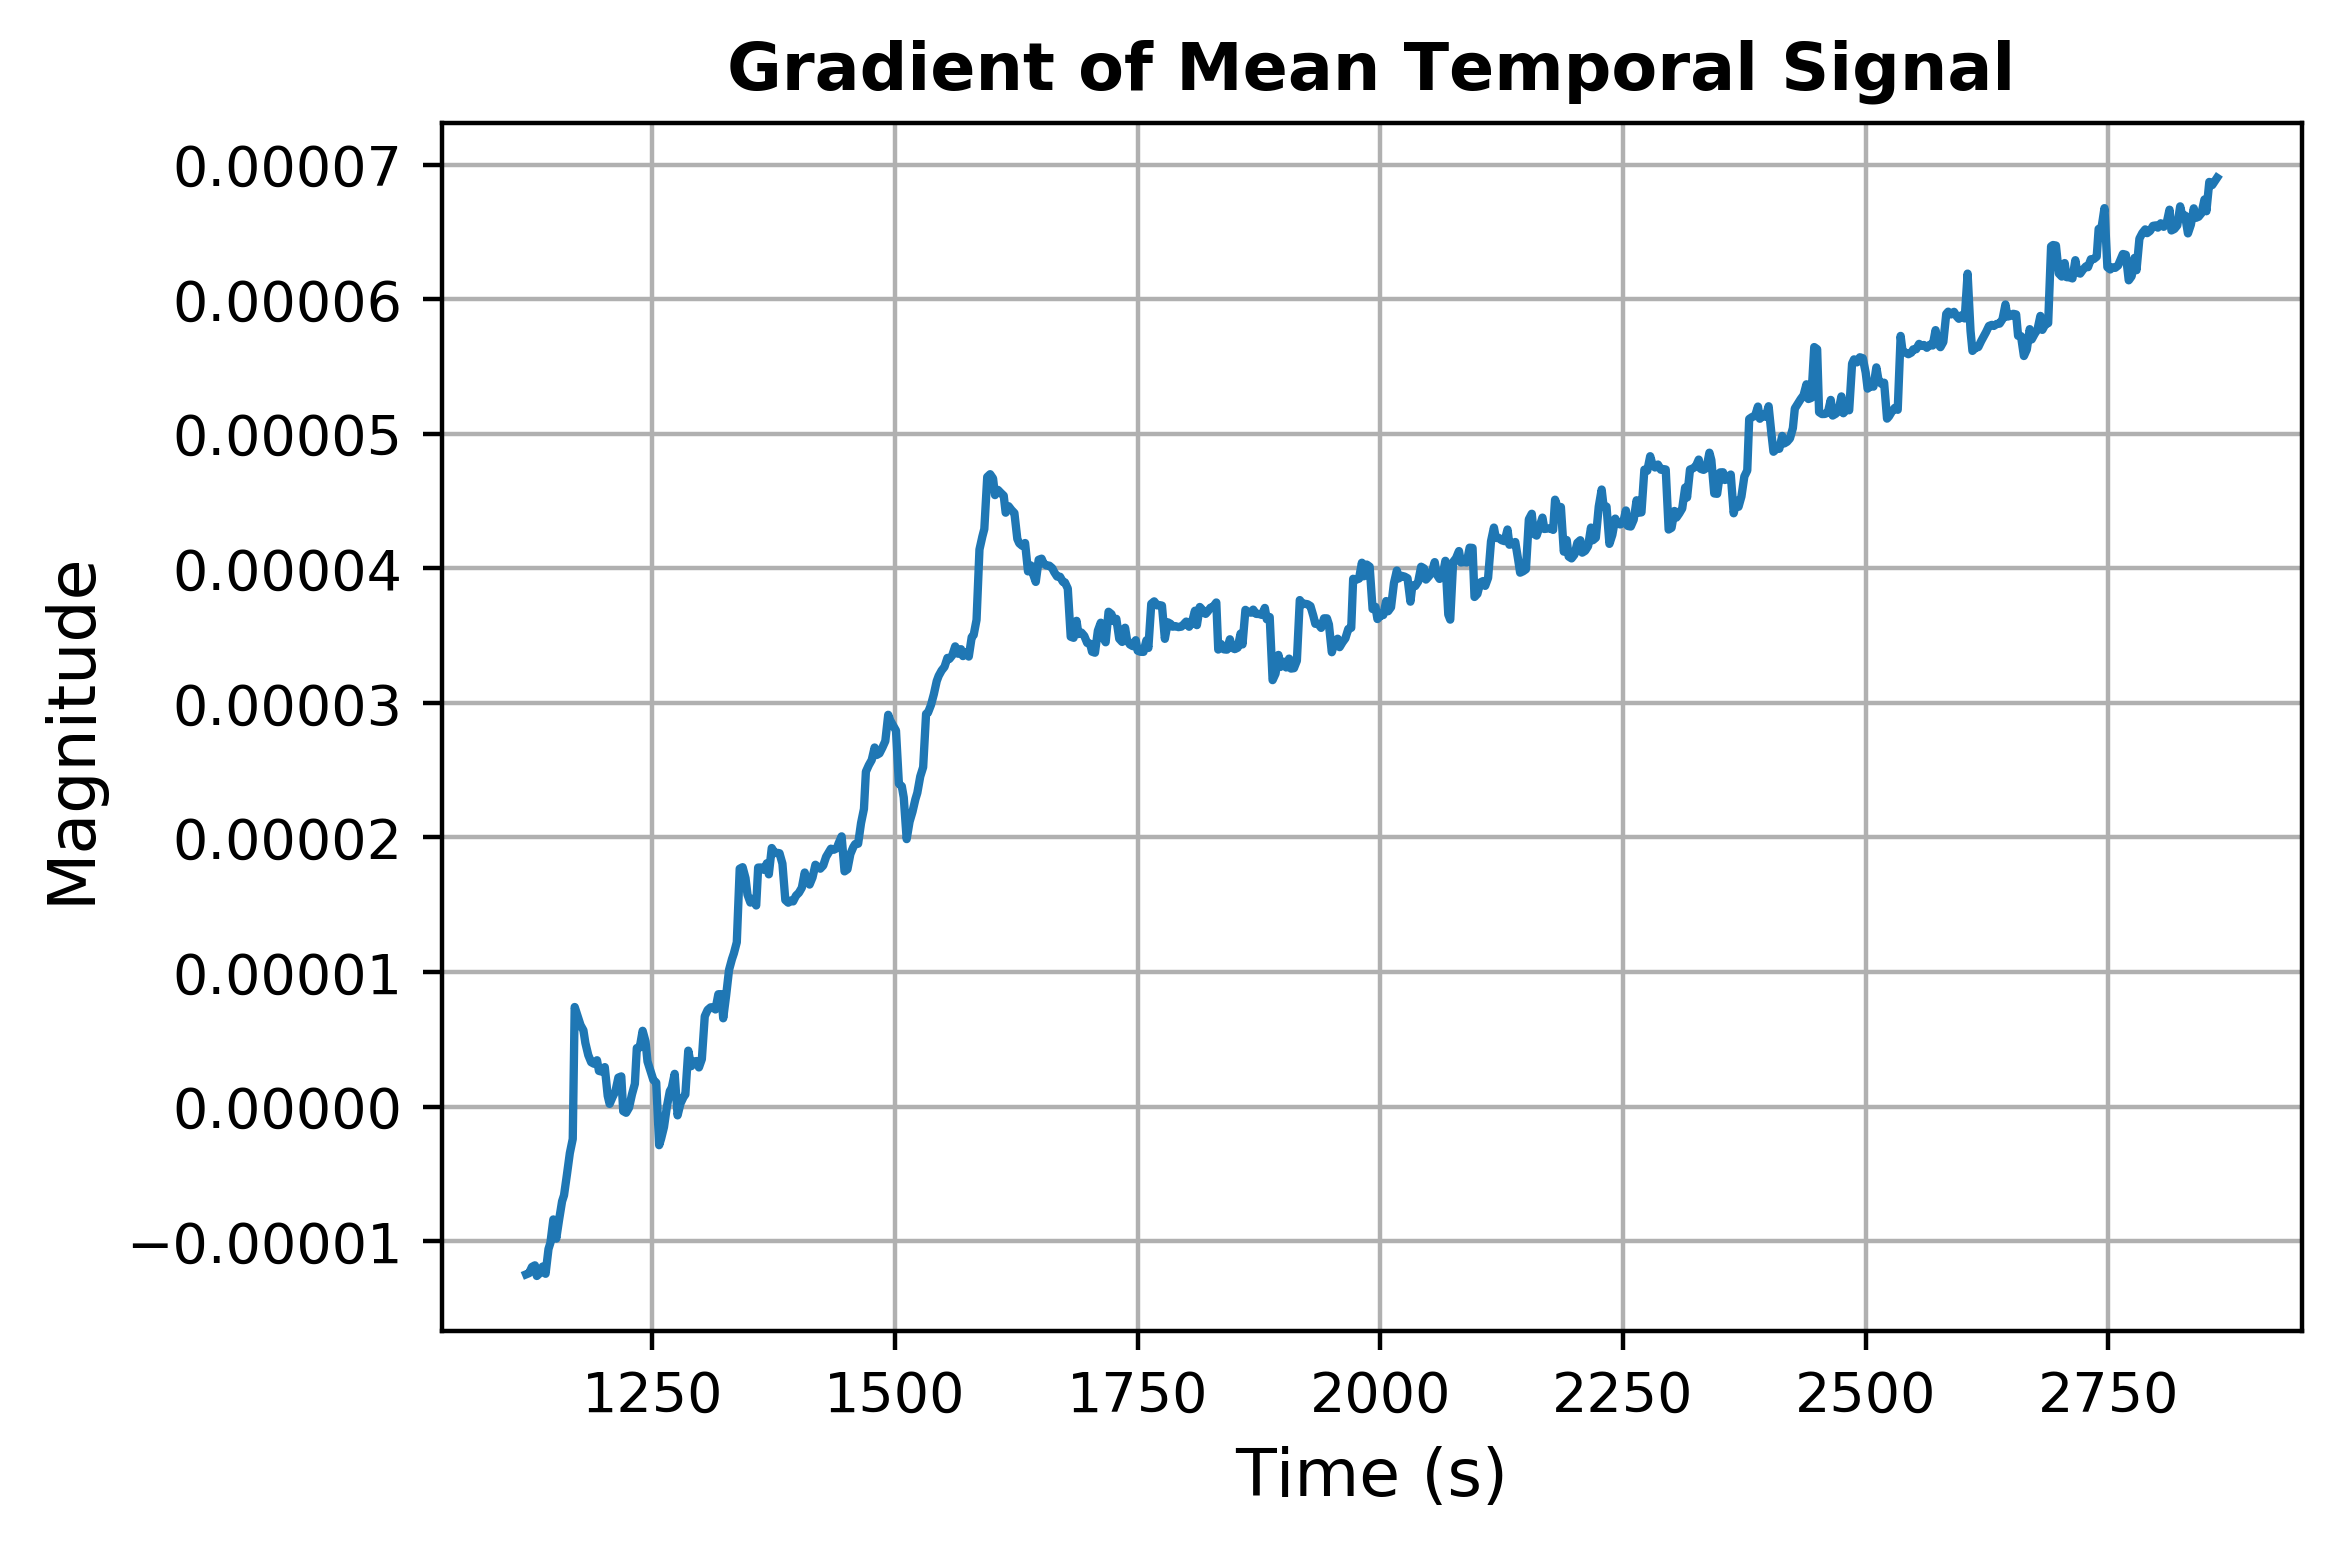

In [252]:
plt.figure(figsize=(6,4), dpi=400)
plt.ylabel('Magnitude', fontsize=12)
plt.xlabel('Time (s)', fontsize=12)
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle="--")
plt.title('Gradient of Mean Temporal Signal', fontweight='bold')
plt.plot(remaining_time_sample[1:], grad)
plt.savefig('Results/mean_temporal_grad.png', bbox_inches='tight')